**Autor:** [Eriberto Oliveira do Nascimento](https://englishphonetics.net/about-us.html)<br>
**Data de criação:** 17/02/2019<br>
**Última modificação:** 07/05/2023<br>
**Descrição:** Rede Neural Convolutional Variacional AutoCodificadora (CVAE) e Transferência de Aprendizagem Profunda com função de perda personalizada. <br>
**Descrição Longa:** Esse é o código desenvolvimento para a tese de doutorado - DESENVOLVIMENTO DA TRANSFERÊNCIA DE APRENDIZAGEM VIA REDES
NEURAIS ARTIFICIAIS PROFUNDAS NA MODELAGEM DO ÍNDICE DE
TRANSMISSÃO DA FALA <br>

**Author:** [Eriberto Oliveira do Nascimento](https://englishphonetics.net/about-us.html)<br>
**Date created:** 2019/17/02<br>
**Last modified:** 2023/05/01<br>
**Description:** Convolutional Variational AutoEncoder (CVAE) and Deep Transfer Learning with a custom loss function. <br>
**Long Description:** This is the development code for the doctoral thesis - DEVELOPMENT OF DEEP TRANSFER TRANSFER LEARNING VIA ARTIFICIAL NEURAL NETWORKS IN MODELING THE INDEX OF
SPEECH TRANSMISSION. <br>

In [1]:
"""### 1 - Setup"""
#from __future__ import print_function
# -*- coding: utf-8 -*-

import sys
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.utils import np_utils

# prerequisites for the CVAE 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import objectives
from scipy.stats import norm

import pandas as pd
!pip install acoustics

     |████████████████████████████████| 3.5 MB 14.0 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for acoustics: filename=acoustics-0.2.6-py3-none-any.whl size=68184 sha256=c08d6fc4a266dd4b16ad6cd149a20ef7c59ad01e6a72061016e53b5b966828fb
  Stored in directory: /root/.cache/pip/wheels/8b/9e/1e/833eb9b3b87ab7a6e96dc7df79992e79f5601029ae9398ffe1
Successfully built acoustics
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


# 1 - Geração sintética da Resposta Impulsiva de Sala
### 1 - Synthetic room impulsive (RIR) response generation

In [2]:
# !pip install pyroomacoustics==0.4.1
# !pip install matplotlib==3.2.2

In [3]:
"""
This example creates a room with reverberation time specified by inverting Sabine's formula.
This results in a reverberation time slightly longer than desired.
The simulation is pure image source method.
"""
import argparse

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import librosa
# Uncoment this module to run it localy
# import pyroomacoustics as pra
import random
import time

def RIR_generator(signal_excitation):
    
    methods = ["ism", "hybrid"]

    if __name__ == "__main__":

        parser = argparse.ArgumentParser(
            description="Simulates and adds reverberation to a dry sound sample."
        )
        parser.add_argument(
            "--method",
            "-m",
            choices=methods,
            default=methods[1],
            help="Simulation method to use",
        )
        
        args = parser.parse_args()

        # The desired reverberation time and dimensions of the room
        rt60_tgt = 2*random.random() + 0.1; # [seconds]
        rt60_tgt =round(rt60_tgt,2)
        room_dim = random.sample(range(5, 20), 3); # [meters]
        room_dim[2] = int(np.array(random.sample(range(2, 5), 1)))
        
        print(room_dim)

        # import a mono wavfile as the source signal
        # the sampling frequency should match that of the room
        fs, audio = wavfile.read(signal_excitation)

        # We invert Sabine's formula to obtain the parameters for the ISM simulator
        e_absorption, max_order = pra.inverse_sabine(rt60_tgt, room_dim)

        # Create the room
        if args.method == "ism":
            room = pra.ShoeBox(
                room_dim, fs=fs, materials=pra.Material(e_absorption), max_order=max_order
            )
        elif args.method == "hybrid":
            room = pra.ShoeBox(
                room_dim,
                fs=fs,
                materials=pra.Material(e_absorption),
                max_order=3,
                ray_tracing=True,
                air_absorption=True,
            )

        fig, ax = room.plot()

        # place the source in the room
        source_pos = np.array(room_dim)/2;
        source_pos[2] = 1.5
        source_pos = source_pos.tolist()

        # print(source_pos)
        
        # source_pos = [2,2,1.5]
        room.add_source(source_pos, signal=audio, delay=0.5)

        # define the locations of the microphones
        
        mic1 =   np.round( np.array(source_pos )+ np.array( [source_pos[0]*0.4, 0, 0]), 2)
        # mic2 =   np.round(np.array(source_pos )+ np.array( [-source_pos[0]/2.5, 0, 0]), 2)
        # mic3 =   np.round( np.array(source_pos )+ np.array( [0, source_pos[1]/2.5, 0]), 2)
        mic4 =   np.round( np.array(source_pos )+ np.array( [0, -source_pos[1]/2.5, 0]), 2 )

        mic1 = mic1.tolist()
        # mic2 = mic2.tolist()
        # mic3 = mic3.tolist()
        # mic4 = mic4.tolist()

        fig, ax = room.plot()
        ax.set_xlim([-1, 10])
        ax.set_ylim([-1, 10]);

        
        mic_locs = np.c_[
            mic1, mic4, 
        ]
        
        """
         mic_locs = np.c_[
              [1,1,0.5], [1, 0.5, 2],  # mic 1  # mic 2
          ]
        """

        # finally place the array in the room
        room.add_microphone_array(mic_locs)

        # Run the simulation (this will also build the RIR automatically)
        room.simulate()
        
        """
          room.mic_array.to_wav(
              'Excitacao23.wav',
              norm=True,
             bitdepth=np.int16,
          )
        """
        # measure the reverberation time
        rt60 = room.measure_rt60()
        print("The desired RT60 was {}".format(rt60_tgt))
        print("The measured RT60 is {}".format(rt60[1, 0]))

        #Create a plot
        plt.figure()

        # plot one of the RIR. both can also be plotted using room.plot_rir()
        rir_1_0 = room.rir[1][0]
        rir_2_0 = room.rir[0][0]
        
        plt.subplot(2, 1, 1)
        plt.plot(np.arange(len(rir_1_0)) / room.fs, rir_1_0)
        plt.title("The RIR from source 0 to mic 1")
        plt.xlabel("Time [s]")

        # plot signal at microphone 1
        plt.subplot(2, 1, 2)
        plt.plot(room.mic_array.signals[1, :])
        plt.title("Microphone 1 signal")
        plt.xlabel("Time [s]")

        plt.tight_layout()
        plt.show()
        
        librosa.output.write_wav('Pyroom_mic1_Dim' + str(room_dim) + '_RT_' + str(round(rt60_tgt,2)) + '_seg' +str(int(round(time.time(),0)))+'.wav', room.rir[1][0], room.fs, norm=False)
        librosa.output.write_wav('Pyroom_mic2_Dim' + str(room_dim) + '_RT_' + str(round(rt60_tgt,2)) + '_seg' + str(int(round(time.time(),0)))+'.wav', room.rir[0][0], room.fs, norm=False)

def generate_RIR():
    i = 0;
    # i represents the total numbers of RIR generated
    while (i < 2):
        try:
                RIR_generator('Excitacao.wav')
        except Exception:
            # In any case of error during the function execution
            pass

        i = i +1
        print(i)
        
# Uncoment to run the generate_RIR() method that 
# generate the RIR curves
# generate()

# 2 - Geração das amostras de ruído de fundo (BGN)
### 2 - Background noise (BGN) samples generation

In [4]:
# This is the link for all background noise sample applied on this thesis

# 3 - Cálculos de Densidade Espectral de Potência
### 3 - Calculations of Power Spectral Density (PSD)

In [5]:
# !pip install acoustics

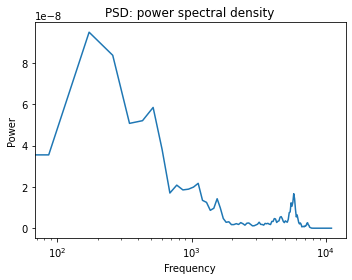

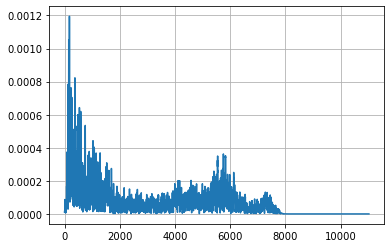

9 9
Tempo de reverberacao
[7.18968802 7.23878439 7.34684224 7.07907771 5.71482262]


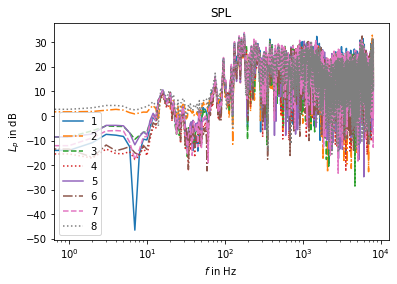

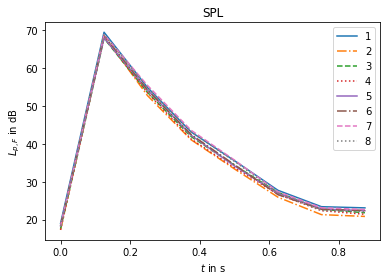

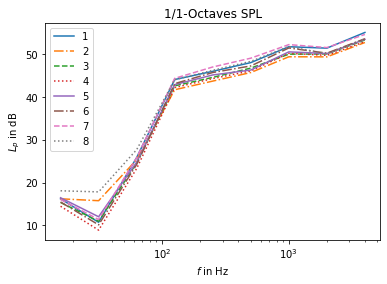

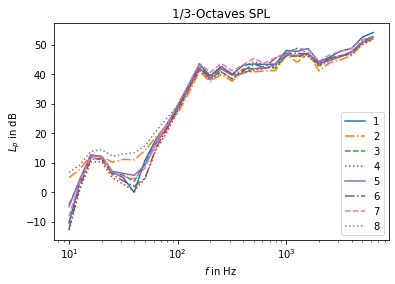

Adicao do ruido
Ruído de fundo
(OctaveBand([  63.09573445  125.89254118  251.18864315  501.18723363 1000.
 1995.26231497]), array([29.49079851, 45.35901501, 52.6403142 , 57.18088183, 60.5129657 ,
       60.34038259]))
Nivel operacional da Fala
(OctaveBand([  63.09573445  125.89254118  251.18864315  501.18723363 1000.
 1995.26231497]), array([[24.10375174, 44.33233499, 45.4527884 , 47.99193677, 51.55837258,
        51.39680853],
       [24.30795494, 41.90483955, 43.12892979, 45.64059328, 49.06455493,
        49.48877308],
       [22.81100585, 42.77121244, 44.07783192, 46.62178626, 49.7860163 ,
        50.11263304],
       [20.90291445, 42.39152248, 43.88872718, 46.07790305, 50.01008075,
        49.70529144],
       [22.79104395, 43.13394698, 44.75175242, 46.25550638, 50.27668502,
        50.19874206],
       [21.86331206, 43.36012631, 45.35550312, 47.11645492, 51.3368037 ,
        50.15050043],
       [23.69645636, 44.61191033, 46.65669001, 48.89946101, 52.10196129,
        51.48876098]

In [6]:
from scipy.io import wavfile
import  scipy 
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal
import librosa
from scipy.fft import fft
from acoustics import Signal
import acoustics

"""
This example creates a room with reverberation time specified by inverting Sabine's formula.
This results in a reverberation time slightly longer than desired.
The simulation is pure image source method.
"""
    
file_name = "/kaggle/input/sti-prediction/RVB2014_type1_rir_largeroom1_far_angla.wav"
sig, sr = librosa.load(file_name)

freqs, psd = signal.welch(sig,sr)

plt.figure(figsize=(5, 4))
plt.semilogx(freqs, psd)
plt.title('PSD: power spectral density')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.tight_layout()
plt.show()

N = len(sig)
T = 1 / sr
yf = fft(sig)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.show()

# Acustica
# RIR
s = Signal.from_wav(file_name)
s.fs
s.channels
s.samples

s.plot_power_spectrum()
s.spectrogram()
s.plot_levels()
s.plot_octaves()
fig = s.plot_third_octaves()

# Nova tr
bands = acoustics.bands.octave(125, 2000)
b = acoustics.room.t60_impulse(file_name, bands, rt='t30')
print("Tempo de reverberacao")
print(b)
plt.show()

# Ruido
print('Adicao do ruido')

filename_BGN = "/kaggle/input/sti-prediction/noise-free-sound-0042.wav"
s2 = Signal.from_wav(filename_BGN)
BGN_octave = acoustics.signal.octaves(s2, 
                                      s2.fs, 
                                      density=False, 
                                      frequencies=[ 63., 
                                                   125., 
                                                   250., 
                                                   500., 
                                                   1000., 
                                                   2000], 
                                      ref=2e-05)

RIR_level  = Signal.from_wav(file_name)

Speech_level = acoustics.signal.octaves(RIR_level, 
                                        RIR_level.fs, 
                                        density=False, 
                                        frequencies=[63., 
                                                     125., 
                                                     250., 
                                                     500., 
                                                     1000., 
                                                     2000], 
                                        ref=2e-05)

print('Ruído de fundo')
print(BGN_octave)

print('Nivel operacional da Fala')
print(Speech_level)

print("SNR")
SNR = Speech_level[1] - BGN_octave[1]
print(SNR)

# 4 - Criação do Conjunto de Dados STI (Domínios de Origem e Alvo)
### 4 - Creation of the STI (Source-Target Domains) Dataset

In [7]:
import os
import glob
import acoustics
from acoustics import Signal
import numpy as np
import math
import librosa
import matplotlib.pyplot as plt
import random
import pandas as pd
import os
from scipy import signal
from numpy import savez_compressed

"""
- Simulated STI values calculated using Shoreder Equation
"""

def BGN_audios(folder):
   
    """
    Recursively converts WAV to spetogram arrays
    folder - folder to convert.
    """

    allFiles = []
    
    for root, dirs, files in os.walk(folder):
        allFiles += [os.path.join(root, f) for f in files
                     if f.endswith('.wav')]

    return allFiles

def RIR_audios(folder):
   
    """
    Recursively converts WAV to spetogram arrays
    folder - folder to convert.
    """
    
    allFiles = []
    
    for root, dirs, files in os.walk(folder):
        allFiles += [os.path.join(root, f) for f in files
                     if f.endswith('.wav')]

    return allFiles
        
def RIR_BGN_2_STI(RIR_file, BGN_file, id_number):

    sig_BGN, sr_BGN = librosa.load(BGN_file)
    freqs_BGN, psd_BGN = signal.welch(sig_BGN,sr_BGN)
        
    sig_RIR, sr_RIR = librosa.load(RIR_file)
    freqs_RIR, psd_RIR = signal.welch(sig_RIR, sr_RIR)

    # Assegura que avalia frequencias menores que 8000

    psd_BGN = psd_BGN[0:len(freqs_BGN[freqs_BGN < 8000])]
    psd_RIR = psd_RIR[0:len(freqs_RIR[freqs_RIR< 8000])]

    # Interpola
    xvals = np.arange(0,8001,10)
    psd_BGN = np.interp(xvals, freqs_BGN[freqs_BGN < 8000], psd_BGN)
    psd_RIR = np.interp(xvals, freqs_RIR[freqs_RIR< 8000], psd_RIR)

    # Normaliza a potencia
    psd_BGN = 10 * np.log10(psd_BGN)
    psd_RIR = 10 * np.log10(psd_RIR)
    

    RT_octave = acoustics.room.t60_impulse(RIR_file, 
                                           acoustics.bands.octave(125, 8000),
                                           rt='t30')

    dummy_BGN = Signal.from_wav(BGN_file)
    BGN_octave = acoustics.signal.octaves(dummy_BGN, 
                                          dummy_BGN.fs,
                                          density=False,  
                                          frequencies=acoustics.bands.octave(125, 8000), 
                                          ref=2e-05)
    
    Ln = BGN_octave[1]
    Op_SL_octave = [61.4, 65.6, 62.3, 56.8, 51.3, 42.6, 33.6] # conforme a norma

    # s =  os.path.basename(RIR_file)
    # start = s.find("[") + len("["); end = s.find("]"); substring = s[start:end]
    # chunks = substring.split(',')
    # V = int(chunks[0]) * int(chunks[1]) * int(chunks[2])
    # q = 2;

    # Classroom noise-to-signal
    # Classroom_SNR = 0.0032*V*q*(1/RT_octave)* np.exp(0.16/RT_octave) * 
    #  10**( 0.1*(Ln - Op_SL_octave) )
    
    modulation_freq = np.array([0.63,
                                0.8, 
                                1.0, 
                                1.25, 
                                1.6, 
                                2.0, 
                                2.5, 
                                3.15,
                                5.0, 
                                6.3, 
                                8.0, 
                                10, 
                                12.5])
    
    octave_freq = np.array([125, 250, 500, 1000, 2000, 4000, 8000])
    
    # Inicialization
    
    mTF = np.zeros((len(modulation_freq), len(octave_freq)))
    SNR = np.zeros((len(modulation_freq), len(octave_freq)))
    TI = np.zeros((len(modulation_freq), len(octave_freq)))
    MTI = np.zeros(len(octave_freq))
    
    # weighing
    alphas_Males = np.array([0.085, 0.127, 0.230, 0.233, 0.309, 0.224, 0.173])
    betas_Males =  np.array([0.085, 0.078, 0.065, 0.011, 0.047, 0.095])
   
    for m in range(0,mTF.shape[0]):
        
        for octave in range(0,mTF.shape[1]):

            mTF[m,octave] = (( 1 + (2*math.pi*modulation_freq[m]*RT_octave[octave]/ 13.82)**2 )**
                             (-1/2))*(1 + 10**( -(Op_SL_octave[octave]  - Ln[octave])/10 ))**(-1)

           # mTF[m,octave] = (( 1 + (2*math.pi*modulation_freq[m]*RT_octave[octave]/ 13.82)**2 )**(-1/2))* (1 +  Classroom_SNR[octave])**(-1)
            SNR[m,octave] = 10 * np.log10( mTF[m,octave] / (1 - mTF[m,octave] ))

            if SNR[m,octave] > 15:
                 SNR[m,octave] = 15
            if SNR[m,octave] < -15:
                 SNR[m,octave] = -15 

            TI[m,octave] = (SNR[m,octave] + 15 ) / 30
            
            MTI[octave] = ( 1 / len(modulation_freq) ) * sum( TI[:,octave])

            if MTI[octave] > 1:
                 MTI[octave] = 1

            STI = np.dot(alphas_Males,MTI)

    #  return [id_number, np.round(STI,3), np.round(RT_octave,3), np.round( BGN_octave[1],3)]
    room_id = id_number  * np.ones(( len(xvals ), 1) )
    room_STI = np.round(STI,3) * np.ones(( len(xvals ), 1) )
    
    """
      df = pd.DataFrame({'Room_id': room_id, 
                         'STI': room_STI,
                         'Frequ': np.transpose(xvals),
                         'PSD_RIR':  psd_RIR,
                         'PSD_BGN': psd_BGN
                         },
                        index = xvals
                        )
    """
    output = np.concatenate([room_id, room_STI, 
                             xvals.reshape(len(xvals),1),
                             psd_RIR.reshape(len(psd_RIR),1), 
                             psd_BGN.reshape(len(psd_BGN),1) ] , 1)

    return  output

folder_RIR = r"RIR_simuladas"
folder_BGN = r"Background_Noise"

# print("Number of simulated RIR .wav files")
# print(RIR_audios(folder_RIR))
# print("Number of meausured BGB .wav files")
# print(BGN_audios(folder_BGN))

BGN = BGN_audios(folder_BGN)
RIR = RIR_audios(folder_RIR)

# print( RIR_BGN_2_STI(RIR[10], BGN[6], 5) )

# Teste gerar STFT bacgroud
# audio2_STFT_spectogram(BGN[6],5)

# Teste CWT 
# audio2_CWT_spectogram(RIR[20],5)

# Cria amostras

id_number = 0
dummy_RIR = random.randint(0,10500)
dummy_BGN = random.randint(0,686)

def generate_STI_database():
    
    A = RIR_BGN_2_STI(RIR[dummy_RIR], BGN[dummy_BGN], id_number)

    # print(A)
    # print(A.shape)

    id_number = 1
    while id_number < 30001:

        dummy_RIR = random.randint(0,8)
        dummy_BGN = random.sample(range(1, 686), 5)

        for i in dummy_BGN:
            A = np.vstack([A, RIR_BGN_2_STI(RIR[dummy_RIR], BGN[i], id_number )])
            id_number =  id_number + 1
            # pd.DataFrame(A).to_csv("Train_Database_identification.csv")
        print(id_number)

    dataset = pd.DataFrame({'c1': A[:,0], 'c2': A[:,1], 
                            'c3': A[:,2], 'c4': A[:,3], 
                            'c5': A[:,4]})

    # dataset.to_pickle("./dummy.pkl")
    # savez_compressed('data_compres.npz', A)
    # unpickled_df = pd.read_pickle("./dummy.pkl")

# 5 - Treinamento de Autoencoder Variacional (VAE) no Domínio de Origem.
### 5 - Variational Autoencoder (VAE) Training for the Source Domain.

keras version  2.4.3

--- Load, inspect and transform data ---

Load data set from the npz
Number of columns in the dataframe: 5
Number of rows in the dataframe: 24030801

First 20 rows of the dataframe:

    Room-id  STI  Freq - [Hz]  PSD(RIR)  PSD(BGN)
0       0.0    1          0.0    -102.1     -53.7
1       0.0    1         10.0     -99.6     -52.3
2       0.0    1         20.0     -98.0     -51.3
3       0.0    1         30.0     -96.9     -50.5
4       0.0    1         40.0     -96.0     -49.8
5       0.0    1         50.0     -95.2     -49.2
6       0.0    1         60.0     -94.6     -48.7
7       0.0    1         70.0     -94.0     -48.2
8       0.0    1         80.0     -93.5     -47.8
9       0.0    1         90.0     -92.9     -47.6
10      0.0    1        100.0     -92.0     -47.7
11      0.0    1        110.0     -91.3     -47.9
12      0.0    1        120.0     -90.7     -48.0
13      0.0    1        130.0     -90.2     -48.1
14      0.0    1        140.0     -89.8     -

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


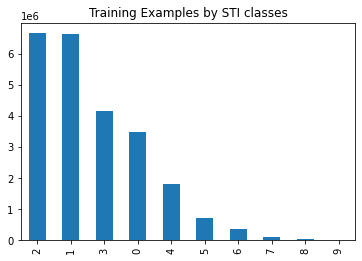

In [8]:
# Load raw data
A = np.load('../input/sti-prediction/data_compres.npz')
A.files
A = A['arr_0']

df = pd.DataFrame({'c1': A[:,0], 'c2': A[:,1], 
                   'c3': A[:,2], 'c4': A[:,3], 
                   'c5': A[:,4]})

"""## 2 - Functions settings
"""

def feature_normalize(dataset):

    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset - mu)/sigma


def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap="coolwarm",
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt="d")
    
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()


def show_basic_dataframe_info(dataframe, preview_rows=20):

    """
    This function shows basic information for the given dataframe
    Args:
        dataframe: A Pandas DataFrame expected to contain data
        preview_rows: An integer value of how many rows to preview
    Returns:
        Nothing
    """

    # Shape and how many rows and columns
    print("Number of columns in the dataframe: %i" % (dataframe.shape[1]))
    print("Number of rows in the dataframe: %i\n" % (dataframe.shape[0]))
    print("First 20 rows of the dataframe:\n")
    # Show first 20 rows
    print(dataframe.head(preview_rows))
    print("\nDescription of dataframe:\n")
    # Describe dataset like mean, min, max, etc.
    # print(dataframe.describe())


def read_data(file_path):

    """
    This function is the ETL process form the STI values
    Args:
        file_path: URL pointing to the pickle file
    Returns:
        A pandas dataframe
    """

    df.rename(columns = {'c1': 'Room-id', 
                         'c2': 'STI', 
                         'c3': 'Freq - [Hz]', 
                         'c4': 'PSD(RIR)', 
                         'c5': 'PSD(BGN)' }, 
                         inplace=True)
        
    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
    label_encoder = LabelEncoder()
    n_bins = 10 # number of classes

    # number of classes 
    y = label_encoder.fit_transform(pd.cut(df['STI'],
                                           n_bins, 
                                           retbins=True)[0]
                                   )

    df['STI'] = y   
    df.dropna(axis=0, how='any', inplace=True)

    return df


def convert_to_float(x):

    try:
        return np.float(x)
    except:
        return np.nan


def feature_normalize(dataset):

    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset - mu)/sigma


def plot_axis(ax, x, y, title):

    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)


def plot_activity(activity, data):

    fig, (ax0, ax1) = plt.subplots(nrows=2,
         figsize=(15, 10),
         sharex=True)
    plot_axis(ax0, data['Freq - [Hz]'], data['PSD(RIR)'], 'PSD(RIR)')
    plot_axis(ax1, data['Freq - [Hz]'], data['PSD(BGN)'], 'PSD(BGN)')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    # plt.show()


def create_segments_and_labels(df, time_steps, step, label_name):

    """
    This function receives a dataframe and returns the reshaped segments
    of BGN, RIR data as well as the corresponding STI labels
    Args:
        df: Dataframe in the expected format
        time_steps: Integer value of the length of a segment that is created
    Returns:
        reshaped_segments
        labels:
    """

    N_FEATURES = 2
    # Number of steps to advance in each iteration (it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    
    segments = []
    labels = []
    
    for i in range(0, len(df) - time_steps, step):
        xs = df['PSD(RIR)'].values[i: i + time_steps]
        ys = df['PSD(BGN)'].values[i: i + time_steps]
        xs = xs[1:]
        ys = ys[1:]
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([xs, ys])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, 
                                   dtype= np.float32).reshape(-1, 
                                                              time_steps-1, 
                                                              N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

"""

## Create training database
"""

# Set some standard parameters upfront

pd.options.display.float_format = '{:.1f}'.format

# sns.set() # Default seaborn look and feel
# plt.style.use('ggplot')

print('keras version ', keras.__version__)

LABELS = ["1","2","3","4","5","6","7","8","9","10"]

# The number of steps within one frequenct range segment
TIME_PERIODS = len(np.arange(0,8001,10))
STEP_DISTANCE = TIME_PERIODS

print("\n--- Load, inspect and transform data ---\n")

print("Load data set from the npz")
read_data(df)

# Describe the data
show_basic_dataframe_info(df, 20)

(df['STI']).value_counts().plot(kind='bar', 
                                title='Training Examples by STI classes')

plt.savefig('STI_distribution_source_domain.pdf')
# plt.show()

print("\n--- Reshape the data into segments ---\n")

# Differentiate between test set and training set
df_train = df[df['Room-id'] <= 25000]
df_test = df[df['Room-id'] > 25000]

# Normalize features for training data set

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
column_names_to_normalize = ['PSD(RIR)','PSD(BGN)']

x = df_train[column_names_to_normalize].values
x_scaled = scaler.fit_transform(x)

df_temp = pd.DataFrame(x_scaled, 
                       columns=column_names_to_normalize, 
                       index=df_train.index)

df_train[column_names_to_normalize] = df_temp

# Now for the test 
x = df_test[column_names_to_normalize].values
x_scaled = scaler.fit_transform(x)
df_temp = pd.DataFrame(x_scaled,
                       columns=column_names_to_normalize, 
                       index=df_test.index)

df_test[column_names_to_normalize] = df_temp

# Round in order to comply to NSNumber from RIR curvers
df_train = df_train.round({'PSD(RIR)': 6, 'PSD(BGN)': 6})
df_test =  df_test.round({'PSD(RIR)': 6, 'PSD(BGN)': 6})

# Reshape the training data into segments, so that 
# they can be processed by the network
# Define column name of the label vector

LABEL = "STI"

x_train, y_train = create_segments_and_labels(df_train,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)


x_test, y_test = create_segments_and_labels(df_test,
                                            TIME_PERIODS,
                                            STEP_DISTANCE,
                                            LABEL)

In [9]:
print("\n--- Reshape data to be accepted by Keras ---\n")

# Inspect x data
print('x_train shape: ', x_train.shape)
print(x_train.shape[0], 'training samples')

# Inspect y data
print('y_train shape: ', y_train.shape)

print('y_test shape: ', y_test.shape)

# Set input_shape / reshape for Keras

print(" Verifying the training dataset dimensions")

print("Dimensoes antes")
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

# Input image dimensions
img_rows = 1600

# Channels go last for TensorFlow backend
print("Dimensão após restruturacao - treino")
x_train_reshaped = x_train.reshape(x_train.shape[0], img_rows)
print(x_train_reshaped.shape)

# Now verifies the test
print("Dimensão após restruturacao - teste")
x_test_reshaped = x_test.reshape(x_test.shape[0], img_rows)
print(x_test_reshaped.shape)

x_tr = x_train_reshaped
x_te = x_test_reshaped


--- Reshape data to be accepted by Keras ---

x_train shape:  (25000, 800, 2)
25000 training samples
y_train shape:  (25000,)
y_test shape:  (4999,)
 Verifying the training dataset dimensions
Dimensoes antes
x_train shape: (25000, 800, 2)
x_test shape: (4999, 800, 2)
Dimensão após restruturacao - treino
(25000, 1600)
Dimensão após restruturacao - teste
(4999, 1600)


## 5.1 - Estatísticas de treinamento para o domínio de origem
#### 5.1 - Training Statistics for the Source Domain

0.19467684410519695 0.1438076506267107


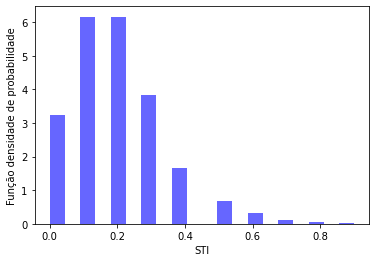

In [10]:
### Fitting 
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

# Extract the column from the dataframe 
# and convert it to a numpy array
data = (df['STI']/10).values

# Fit a Gaussian distribution to the data
mu, std = stats.norm.fit(data)

# Plot the histogram
plt.hist(data, bins=20, density=True, alpha=0.6, color='b')

# Add a title and labels
plt.xlabel('STI')
plt.ylabel('Função densidade de probabilidade')

# Show the plot
print(mu, std)

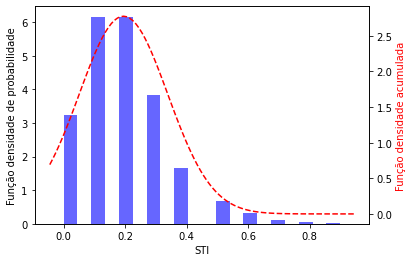

0.19467684410519695 0.1438076506267107


In [11]:
# Plot the histogram
plt.hist(data, bins=20, density=True, alpha=0.6, color='b')

# Plot the Gaussian fit
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)

#plt.plot(x, c, 'r', linewidth=2)
# Add a title and labels
plt.xlabel('STI')
plt.ylabel('Função densidade de probabilidade')

ax2 = plt.twinx()

# plot the data for the second y-axis
ax2.plot(x, p, 'r--')
ax2.set_ylabel('Função densidade acumulada', color='r')

# show the plot
plt.show()


# Show the plot
print(mu, std)

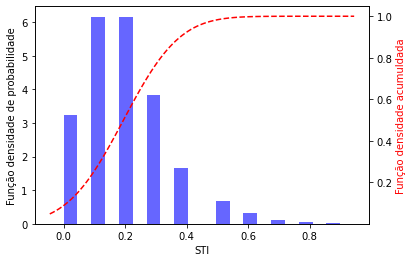

0.19467684410519695 0.1438076506267107


In [12]:
# Plot the histogram
plt.hist(data, bins=20, density=True, alpha=0.6, color='b')

# Plot the Gaussian fit
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
c = stats.norm.cdf(x, mu, std)

#plt.plot(x, c, 'r', linewidth=2)
# Add a title and labels
plt.xlabel('STI')
plt.ylabel('Função densidade de probabilidade')

ax2 = plt.twinx()

# plot the data for the second y-axis
ax2.plot(x, c, 'r--')
ax2.set_ylabel('Função densidade acumuldada', color='r')

# show the plot
plt.show()


# Show the plot
print(mu, std)

## 5.2 -  Treinamento da rede autoencoder variacional
#### 5.2 - VAE training

In [13]:
"""## 3 - Reescaling the data for the VAE traning"""

print(" Build the VAE models and set is parameters ")
batch_size, n_epoch = 1, 5
n_hidden, z_dim = 64, 2 # Here changes the z-dimension (latent space)

# encoder
x = Input(shape=(x_tr.shape[1:]))
x_encoded = Dense(n_hidden, activation='relu')(x)
x_encoded = Dense(n_hidden//2, activation='relu')(x_encoded)

mu = Dense(z_dim)(x_encoded)
log_var = Dense(z_dim)(x_encoded)

# sampling function
def sampling(args):
    mu, log_var = args
    eps = K.random_normal(shape=(batch_size, z_dim), mean=0., stddev=1.0)
    return mu + K.exp(log_var) * eps

z = Lambda(sampling, output_shape=(z_dim,))([mu, log_var])

# decoder
z_decoder1 = Dense(n_hidden//2, activation='relu')
z_decoder2 = Dense(n_hidden, activation='relu')
y_decoder = Dense(x_tr.shape[1], activation='sigmoid')

z_decoded = z_decoder1(z)
z_decoded = z_decoder2(z_decoded)
y = y_decoder(z_decoded)

# loss
reconstruction_loss = objectives.binary_crossentropy(x, y) * x_tr.shape[1]
kl_loss = 0.5 * K.sum(K.square(mu) + K.exp(log_var) - log_var - 1, axis = -1)
vae_loss = reconstruction_loss + kl_loss

# build model
vae = Model(x, y)
vae.add_loss(vae_loss)

# Add metrics
vae.add_metric(reconstruction_loss, name='reconstruction_loss')
vae.add_metric(kl_loss, name='kl_loss')
vae.add_metric(vae_loss, name='vae_loss')

vae.compile(optimizer='rmsprop')
vae.summary()

# train
vae.fit(x_tr,
       shuffle=True,
       epochs=n_epoch,
       batch_size=batch_size,
       validation_data=(x_te, None), verbose=1)

# build encoder
encoder = Model(x, mu)
encoder.summary()

 Build the VAE models and set is parameters 
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1600)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           102464      input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           2080        dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            66          dense_1[0][0]                    
_________________________________________________

## 5.3 - Valores da função perda da rede VAE
#### 5.3 - VAE losses values

In [14]:
vae.history

In [15]:
# list all data in history
print(vae.history.history.keys())

dict_keys(['loss', 'reconstruction_loss', 'kl_loss', 'vae_loss', 'val_loss', 'val_reconstruction_loss', 'val_kl_loss', 'val_vae_loss'])


In [16]:
print(vae.history.history['loss'])

[959.5841064453125, 954.8483276367188, 954.2412109375, 954.0896606445312, 953.8755493164062]


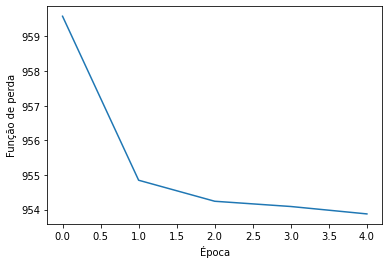

In [17]:
# Extract the loss values from the history and plot it
loss_values = vae.history.history['loss']

# Plot the loss values over time
plt.plot(loss_values)
plt.xlabel('Época')
plt.ylabel('Função de perda')
plt.show()

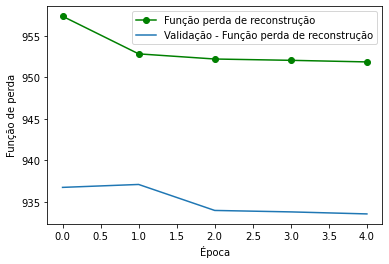

In [18]:
#List of all possible metrics to plot: 

'''
dict_keys(['loss', 'reconstruction_loss', 
           'kl_loss', 'vae_loss', 
           'val_loss', 'val_reconstruction_loss', 
           'val_kl_loss', 'val_vae_loss'])
'''

# Extract the loss values from the history
component1_values = vae.history.history['reconstruction_loss']
component2_values = vae.history.history['val_reconstruction_loss']

# Plot the loss values over time
plt.plot(component1_values, 'go-', label='Função perda de reconstrução')
plt.plot(component2_values, label='Validação - Função perda de reconstrução')
plt.xlabel('Época')
plt.ylabel('Função de perda')
plt.legend()
plt.show()

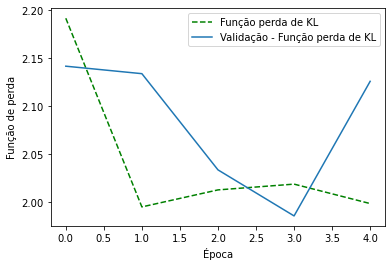

In [19]:
# Extract the KL loss values from the history and plot it
component1_values = vae.history.history['kl_loss']
component2_values = vae.history.history['val_kl_loss']

# Plot the loss values over time
plt.plot(component1_values, 'g--', label='Função perda de KL')
plt.plot(component2_values, label='Validação - Função perda de KL')

plt.xlabel('Época')
plt.ylabel('Função de perda')
plt.legend()
plt.show()

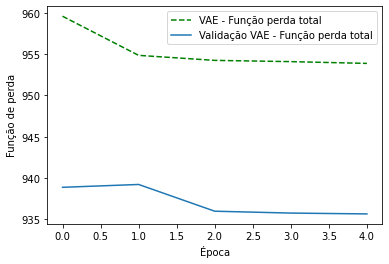

In [20]:
# Extract the loss values from the history
component1_values = vae.history.history['vae_loss']
component2_values = vae.history.history['val_vae_loss']

# Plot the loss values over time
plt.plot(component1_values, 'g--', label='VAE - Função perda total')
plt.plot(component2_values, label='Validação VAE - Função perda total')

plt.xlabel('Época')
plt.ylabel('Função de perda')
plt.legend()
plt.show()

# 6 - Otimização de hiperparâmetros (HPO) do modelo VAE
### 6 - Hyperparameter Optimization (HPO) of the VAE model

In [21]:
# You can use Matplotlib instead of Plotly for visualization by 
#  simply replacing `optuna.visualization` with
# `optuna.visualization.matplotlib` in the following examples.

import optuna
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

SEED = 42

np.random.seed(SEED)

from keras.backend import clear_session
from keras.utils.vis_utils import plot_model
from sklearn.metrics import mean_squared_error

In [22]:
def start_Autoencoder(features,trials,  plot_graph = False):

  # Variational Autoencoder structure
  def create_model(activation, layers_num, zdim_num, kernel_initializer):
    clear_session()
    
    batch_size, n_epoch = 1, 1
    n_hidden, z_dim = layers_num, zdim_num 
    # Here change the dimension (Model hyperparameter)

    # encoder
    x = Input(shape=(x_tr.shape[1:]))
    x_encoded = Dense(n_hidden, 
                      activation=activation, 
                      kernel_initializer=kernel_initializer)(x)
    x_encoded = Dense(n_hidden//2, activation=activation)(x_encoded)

    mu = Dense(z_dim)(x_encoded)
    log_var = Dense(z_dim)(x_encoded)

    # sampling function
    def sampling(args):
        mu, log_var = args
        eps = K.random_normal(shape=(batch_size, z_dim), mean=0., stddev=1.0)
        return mu + K.exp(log_var) * eps

    z = Lambda(sampling, output_shape=(z_dim,))([mu, log_var])

    # decoder
    z_decoder1 = Dense(n_hidden//2, activation='relu')
    z_decoder2 = Dense(n_hidden, activation='relu')
    y_decoder = Dense(x_tr.shape[1], activation='sigmoid')

    z_decoded = z_decoder1(z)
    z_decoded = z_decoder2(z_decoded)
    y = y_decoder(z_decoded)

    # loss
    reconstruction_loss = objectives.binary_crossentropy(x, y) * x_tr.shape[1]
    kl_loss = 0.5 * K.sum(K.square(mu) + K.exp(log_var) - log_var - 1, axis = -1)
    vae_loss = reconstruction_loss + kl_loss

    # build model
    vae = Model(x, y)
    
    vae.add_loss(vae_loss)
    # Add metrics
    vae.add_metric(reconstruction_loss, name='reconstruction_loss')
    vae.add_metric(kl_loss, name='kl_loss')
    vae.add_metric(vae_loss, name='vae_loss')
    autoencoder = vae

    return autoencoder

  # Objective function to optimize by OPTUNA module
    
  def objective(trial):
    activation = trial.suggest_categorical("activation", 
                                           ["relu", "sigmoid", "swish"])
    layers_num = trial.suggest_int("layers_num", 2,64)
    zdim_num = trial.suggest_int("dim_latent_z", 2,128)
    if (activation == "relu"):
      model = create_model(activation, 
                           layers_num, 
                           zdim_num, 
                           kernel_initializer="HeUniform")
    else:
      model = create_model(activation,
                           layers_num,
                           zdim_num,
                           kernel_initializer="GlorotUniform")
    
    model.compile(optimizer='rmsprop')
    
    # Implement early stopping criterion. 
    # Training process stops when there is no improvement during 50 iterations
    
    callback = keras.callbacks.EarlyStopping(monitor='loss', patience=50)
    history = model.fit(features, 
                        features,
                        batch_size = 1,
                        epochs=1,
                        callbacks = [callback], 
                        verbose = 0)
    
    return history.history["loss"][-1]
  
  study = optuna.create_study(direction='minimize')
  study.optimize(objective, n_trials=trials)
    
  # Create final model with the best hyperparams
  print('Best hyperparams found by Optuna: \n', study.best_params)
  if (study.best_params['activation'] == "relu"):
    model = create_model(study.best_params['activation'],
                         int(study.best_params['layers_num']),
                         int(study.best_params['dim_latent_z']),
                         kernel_initializer="HeUniform")
  else:
    model = create_model(study.best_params['activation'],
                        int(study.best_params['layers_num']),
                        int(study.best_params['dim_latent_z']),
                        kernel_initializer="GlorotUniform")

  model.compile(optimizer='rmsprop')
  model.summary()
    
  # Implement early stopping criterion. 
  # Training process stops when there is no improvement during a certatin number
  # of iterations
    
  callback = keras.callbacks.EarlyStopping(monitor='loss', patience=50)
  history = model.fit(features, 
                      features,
                      batch_size = 1,
                      epochs=2, 
                      callbacks = [callback],
                      verbose = 0)

  result = model.predict(features)
    
  # Result evaluation
  print(f'RMSE Autoencoder: {np.sqrt(mean_squared_error(features, result))}')
  print('')

  # Following values are returned: extracted_f || MSE || OPTUNA best hyperparams

  return mean_squared_error(features, result), study.best_params, study


# Run the HPO on the VAE

Acoder_MSE, Acoder_hyperparams, Study = start_Autoencoder(features = x_tr,
                                  trials = 5,
                                  plot_graph=True)

[I 2023-05-22 21:07:00,320] A new study created in memory with name: no-name-22f3c81d-0ebb-4eb0-b7a5-25b720863c8a
[I 2023-05-22 21:07:49,672] Trial 0 finished with value: 985.1223754882812 and parameters: {'activation': 'relu', 'layers_num': 56, 'dim_latent_z': 60}. Best is trial 0 with value: 985.1223754882812.
[I 2023-05-22 21:08:40,918] Trial 1 finished with value: 988.1760864257812 and parameters: {'activation': 'swish', 'layers_num': 28, 'dim_latent_z': 88}. Best is trial 0 with value: 985.1223754882812.
[I 2023-05-22 21:09:32,457] Trial 2 finished with value: 967.4864501953125 and parameters: {'activation': 'relu', 'layers_num': 49, 'dim_latent_z': 9}. Best is trial 2 with value: 967.4864501953125.
[I 2023-05-22 21:10:22,478] Trial 3 finished with value: 970.4619140625 and parameters: {'activation': 'relu', 'layers_num': 46, 'dim_latent_z': 32}. Best is trial 2 with value: 967.4864501953125.
[I 2023-05-22 21:11:12,000] Trial 4 finished with value: 984.3867797851562 and parameters

Best hyperparams found by Optuna: 
 {'activation': 'relu', 'layers_num': 49, 'dim_latent_z': 9}
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1600)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 49)           78449       input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 24)           1200        dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 9)            225         dense_1[0][0]                   

In [23]:
plot_optimization_history(Study)

In [24]:
plot_param_importances(Study)

In [25]:
optuna.visualization.plot_param_importances(
    Study, target=lambda t: t.duration.total_seconds(), target_name="duration"
)

In [26]:
plot_edf(Study)

In [27]:
plot_contour(Study)

# 7 - Visualização dos Embeddings VAE
### 7 - Visualization of the VAE Embeddings

In [28]:
import matplotlib

cmap = matplotlib.cm.get_cmap('Spectral')

In [29]:
cmap

In [30]:
def plot_representation(features, labels, rep_type):
    fig, axes = plt.subplots(2, 3, figsize=(12,6))
    fig.suptitle('Scatter plot: ' + rep_type + ' 4 features representation', fontsize=16)

    for i, pair in enumerate(combinations([0,1,2,3], 2)):
        for label, color in zip([1,2,3,4,5,6,7,8,9], ['blue', 'green',
                                                      'black', 'yellow', 
                                                      'brown', 'orange',
                                                      'red', 'gray', 
                                                      'olive','gold']):
            
            axes[int(i / 3), int(i % 3)].scatter(features[labels == label, pair[0]], 
                                                features[labels == label, pair[1]], 
                                                c=color,
                                                alpha=0.5,
                                                label = label)
            
            axes[int(i / 3), int(i % 3)].set_xlabel(f'Feature {pair[0]}')
            axes[int(i / 3), int(i % 3)].set_ylabel(f'Feature {pair[1]}')
            axes[int(i / 3), int(i % 3)].legend()
            
    plt.tight_layout()

In [31]:
from sklearn.manifold import TSNE, Isomap
from sklearn.decomposition import PCA
from itertools import combinations

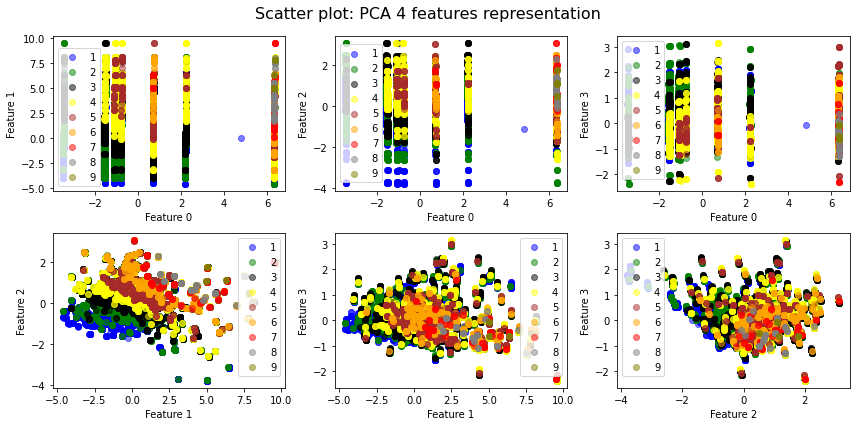

In [32]:
PCA_transformer = PCA(n_components=4)
x_train_reshaped_TSE = np.asarray(x_train_reshaped, dtype='float64')
PCA_representation = PCA_transformer.fit_transform(x_train_reshaped_TSE)

# Visualize the results of the dimensionaly reduction
plot_representation(PCA_representation, y_train, 'PCA')

# 8 - Salvando o modelo do codificador em uma extensão de arquivo .h5
### 8 - Saving the Encoder Model to a .h5 File Extension

In [33]:
# Save weights approaches

#vae.save_weights('my_vae_weights.h5')
#encoder.save("my_h5_model.h5")

# Load weights 
# Calling `save('my_model.h5')` creates a h5 file `my_model.h5`.
#encoder.save("my_h5_model.h5")

# It can be used to reconstruct the model identically.
#reconstructed_model = keras.models.load_model("my_h5_model.h5")

# Let's check: (Test to verify if the model was reload properly)
#np.testing.assert_allclose(
#    encoder.predict(test_input), reconstructed_model.predict(test_input)
#)

# The reconstructed model is already compiled and has retained the optimizer
# state, so training can resume:
#reconstructed_model.fit(test_input, test_target)

In [34]:
# Calling `save('my_model.h5')` creates a h5 file `my_model.h5`.
encoder.save("vae_encoder.h5")

# It can be used to reconstruct the model identically.

# Load the saved model and make predicitions
reconstructed_model = keras.models.load_model("vae_encoder.h5")
x_te_latent_recons = reconstructed_model.predict(x_te, batch_size=1)

# Compare with the orginal encoder model
x_te_latent_origin = encoder.predict(x_te, batch_size=batch_size)

# Compare the results
x_te_latent_origin == x_te_latent_recons

array([[ True,  True],
       [ True,  True],
       [ True,  True],
       ...,
       [ True,  True],
       [ True,  True],
       [ True,  True]])

## 8.2 - Salvando o modelo do codificador como um objeto gráfico do TensorFlow
#### 8.2 Saving the Encoder Model as a TensorFlow Graph Object

In [35]:
import tensorflow as tf

# Save the model
# encoder.save("my_model.model")
encoder.save("my_model.model")

# Load the saved model
tensorflow_graph = tf.saved_model.load("./my_model.model")

# Make predictions 
z_latent = tensorflow_graph(x_te ,False, None).numpy()

# x = np.random.uniform(size=(1600))
# x = np.expand_dims(x, axis=0)
# predicted = tensorflow_graph(x ,False, None).numpy()

# predicted
# Compare the results of the saved model and the original model in memory
np.round(z_latent,4) == np.round(x_te_latent_origin,4)

array([[ True,  True],
       [ True,  True],
       [ True,  True],
       ...,
       [ True,  True],
       [ True,  True],
       [ True,  True]])

## 8.3 - Salvando as previsões do conjunto de dados de treinamento (x_tr_latent) no espaço codificado para modelagem KCPR
#### 8.3 - Saving the Training Dataset Predictions (x_tr_latent) to the Encoded Space for KCPR Modeling

In [36]:
# Important: Generate the z latent encoding  with 128 dimensions, then z = 12

# x_tr
x_tr_latent = encoder.predict(x_tr, batch_size=batch_size)

# Make a pandas dataframe of the latent space and export the data 
x_tr_latent.shape

# Create the padnas dataframe 
dataset_high_z_dim = pd.DataFrame(x_tr_latent)
classes = pd.DataFrame(y_train)

# dataset_high_z_dim.append(classes)
dataset_high_z_dim['classes'] = classes
print(dataset_high_z_dim)

# print(classes)
dataset_high_z_dim.to_csv('dataset_high_z_dim.csv')

         0    1  classes
0     -1.1  0.7        1
1     -1.7  0.5        2
2     -1.6  1.0        4
3     -1.8 -0.2        3
4     -1.7  0.4        2
...    ...  ...      ...
24995 -1.6  1.0        5
24996  0.6  0.1        1
24997  0.5 -0.2        0
24998  0.4 -1.1        1
24999  0.7  3.0        0

[25000 rows x 3 columns]


# 9 - Plotando a visualização do espaço do kernel 2D
### 9 -  Plotting 2D kernel space visualization

In [37]:
#Inspecting the latent space varialbes (z1 and z2)
x_tr_latent

array([[-1.1421251 ,  0.68480766],
       [-1.6586633 ,  0.4615362 ],
       [-1.610394  ,  0.97498417],
       ...,
       [ 0.49641865, -0.21042567],
       [ 0.42095065, -1.0517598 ],
       [ 0.667242  ,  2.9747338 ]], dtype=float32)

## 9.1 - Plotando a representação do espaço latente (z = 2) do treinamento (conjunto de dados de origem)
#### 9.1 Plotting the Latent Space Representation (z = 2) of the Training (Source Dataset)

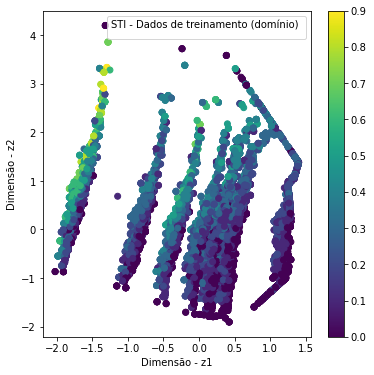

In [38]:
# Plot
plt.figure(figsize=(6, 6))
y_tr = y_train
plt.scatter(x_tr_latent[:, 0], x_tr_latent[:, 1], c=y_tr/10)
plt.colorbar()

plt.legend(title="STI - Dados de treinamento (domínio) ")
plt.xlabel('Dimensão - z1')
plt.ylabel('Dimensão - z2')
#ax.add_artist(legend1)

plt.show()

## 9.2 Plotando a representação do espaço latente (z = 2) do teste (conjunto de dados de origem)
#### 9.2 Plotting the Latent Space Representation (z = 2) of the Testing (Source Dataset)

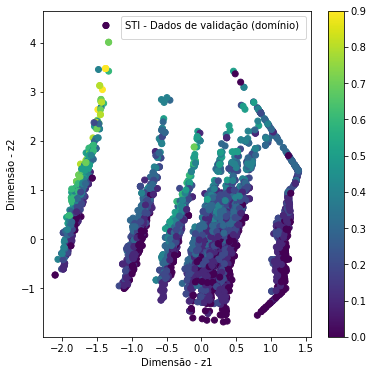

In [39]:
# Make the prediction of the latent space 
x_te_latent = encoder.predict(x_te, batch_size=batch_size)
y_te = y_test  
plt.figure(figsize=(6, 6))
plt.scatter(x_te_latent[:, 0], x_te_latent[:, 1], c = y_te/10 )
plt.legend(title="STI - Dados de validação (domínio) ")
plt.xlabel('Dimensão - z1')
plt.ylabel('Dimensão - z2')
plt.colorbar()

# produce a legend with the unique colors from the scatter
plt.show()

## 9.3 - Reconstruindo o espaço latente VAE via codificador de mapas embuídos (Domínio de origen)
#### 9.3 - Reconstructing VAE Latent Space via Encoder Embedding (Source Domain)

In [40]:
x_tr_latent = encoder.predict(x_tr, batch_size=batch_size)
y_tr = y_train                            
dataset = pd.DataFrame({'z1': x_tr_latent[:, 0], 'z2': x_tr_latent[:, 1], 'STI':  y_tr})
print(dataset)

        z1   z2  STI
0     -1.1  0.7    1
1     -1.7  0.5    2
2     -1.6  1.0    4
3     -1.8 -0.2    3
4     -1.7  0.4    2
...    ...  ...  ...
24995 -1.6  1.0    5
24996  0.6  0.1    1
24997  0.5 -0.2    0
24998  0.4 -1.1    1
24999  0.7  3.0    0

[25000 rows x 3 columns]


### 9.3.1 - Visualização da inferência do histograma do espaço latente
##### 9.3.1 - Visualization of Latent Space Histogram Inference

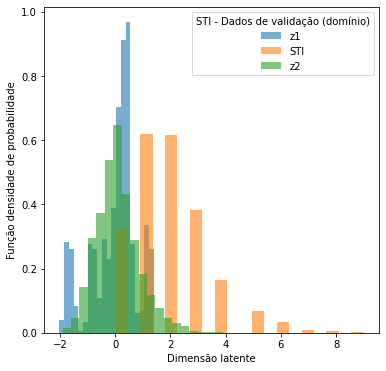

In [41]:
plt.figure(figsize=(6, 6))
dataset['z1'].plot(kind="hist", bins=20, density=True, alpha=0.6 )
dataset['STI'].plot(kind="hist", bins=20, density=True, alpha=0.6)
dataset['z2'].plot(kind="hist", bins=20, density=True, alpha=0.6)

plt.legend(title="STI - Dados de validação (domínio)")
plt.xlabel('Dimensão latente')
plt.ylabel('Função densidade de probabilidade')
plt.show()

### 9.3.2 - IA Explicativa (EAX) - Plotando a reconstrução do modelo codificado em 2 dimensões
##### 9.3.2 - Explainable AI (EAX) - Plotting the Encoded Model Reconstruction in 2-Dimensions

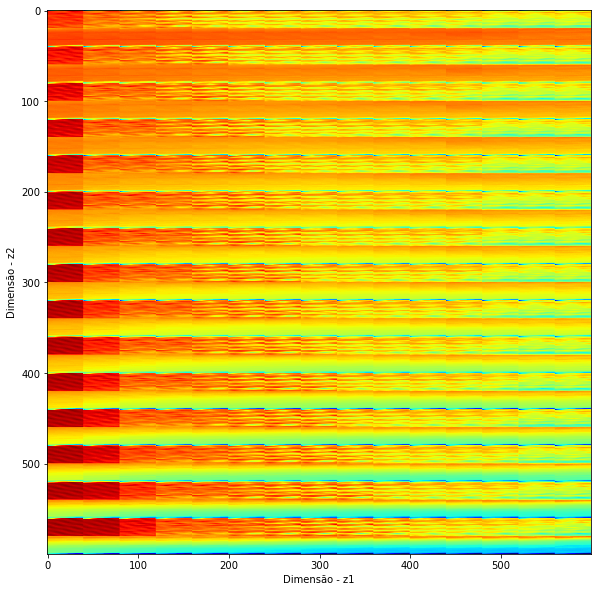

In [42]:
# build decoder
decoder_input = Input(shape=(z_dim,))
_z_decoded = z_decoder1(decoder_input)
_z_decoded = z_decoder2(_z_decoded)
_y = y_decoder(_z_decoded)
generator = Model(decoder_input, _y)

# generator.summary()
# display a 2D manifold of the digits

n = 15 # figure with 15x15 dimensional size
digit_size1 = 40
digit_size2 = 40
figure = np.zeros((digit_size1 * n, digit_size2 * n))

grid_x = norm.ppf(np.linspace(0.05, 0.95, n)) 
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size1, digit_size2)
        figure[i * digit_size1: (i + 1) * digit_size1,
               j * digit_size2: (j + 1) * digit_size2] = digit

plt.figure(figsize=(10, 10))
plt.xlabel('Dimensão - z1')
plt.ylabel('Dimensão - z2')
plt.imshow(figure, cmap='jet')
plt.show()

### 9.3.3 PCA aplicado ao espaço latente durante o treinamento de VAE: z Dim = 2
##### 9.3.3 - PCA Applied to the Latent Space During VAE Training: z Dimension = 2

In [43]:
x_te_latent_recons.shape

(4999, 2)

In [44]:
y_te.min()

0

In [45]:
# Reload data
# PCA_transformer = PCA(n_components=4)
# x_train_reshaped_TSE = np.asarray(x_te_latent_recons, dtype='float64')
# PCA_representation = PCA_transformer.fit_transform(x_train_reshaped_TSE)

# Visualize results
# plot_representation(PCA_representation, y_te, 'PCA')

### 9.3.4 - Visualização da estimativa de densidade do kernel do domínio de origem
##### 9.3.4 - Visualization of the Kernel Density Estimation of the source domain

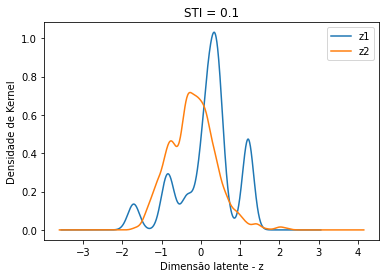

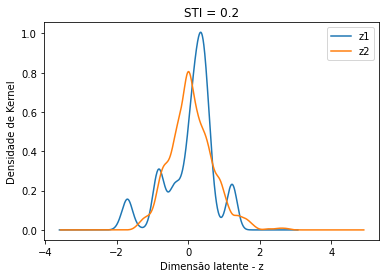

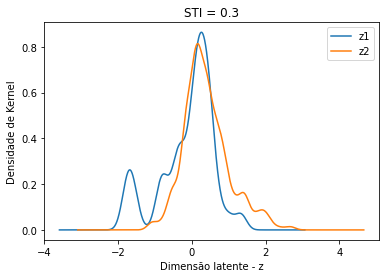

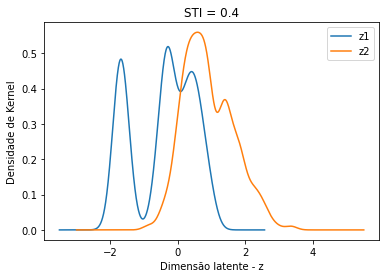

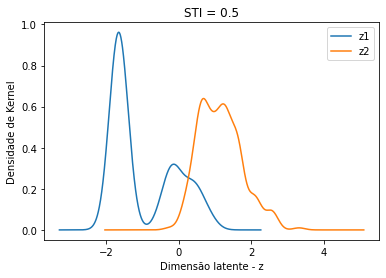

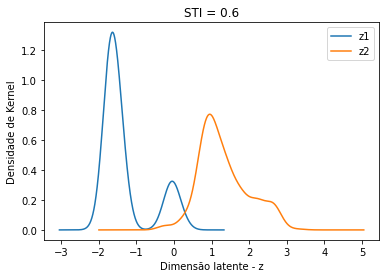

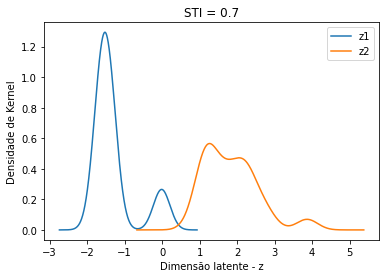

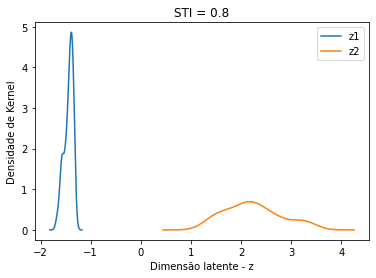

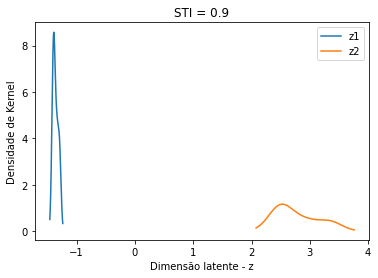

In [46]:
###
is_STI_1 =  dataset['STI'] == 1
is_STI_1_data = dataset[is_STI_1]
#print(is_STI_1_data)
is_STI_1_data = is_STI_1_data[['z1','z2']]
ax = is_STI_1_data.plot.kde()
plt.xlabel('Dimensão latente - z')
plt.ylabel('Densidade de Kernel')
plt.title('STI = 0.1')
plt.show()
###
###
is_STI_1 =  dataset['STI'] == 2
is_STI_1_data = dataset[is_STI_1]
#print(is_STI_1_data)
is_STI_1_data = is_STI_1_data[['z1','z2']]
ax = is_STI_1_data.plot.kde()
plt.xlabel('Dimensão latente - z')
plt.ylabel('Densidade de Kernel')
plt.title('STI = 0.2')
plt.show()
###
is_STI_1 =  dataset['STI'] == 3
is_STI_1_data = dataset[is_STI_1]
#print(is_STI_1_data)
is_STI_1_data = is_STI_1_data[['z1','z2']]
ax = is_STI_1_data.plot.kde()
plt.xlabel('Dimensão latente - z')
plt.ylabel('Densidade de Kernel')
plt.title('STI = 0.3')
plt.show()
###
is_STI_1 =  dataset['STI'] == 4
is_STI_1_data = dataset[is_STI_1]
#print(is_STI_1_data)
is_STI_1_data = is_STI_1_data[['z1','z2']]
ax = is_STI_1_data.plot.kde()
plt.xlabel('Dimensão latente - z')
plt.ylabel('Densidade de Kernel')
plt.title('STI = 0.4')
plt.show()
####
is_STI_1 =  dataset['STI'] == 5
is_STI_1_data = dataset[is_STI_1]
#print(is_STI_1_data)
is_STI_1_data = is_STI_1_data[['z1','z2']]
ax = is_STI_1_data.plot.kde()
plt.xlabel('Dimensão latente - z')
plt.ylabel('Densidade de Kernel')
plt.title('STI = 0.5')
plt.show()
####
is_STI_1 =  dataset['STI'] == 6
is_STI_1_data = dataset[is_STI_1]
#print(is_STI_1_data)
is_STI_1_data = is_STI_1_data[['z1','z2']]
ax = is_STI_1_data.plot.kde()
plt.xlabel('Dimensão latente - z')
plt.ylabel('Densidade de Kernel')
plt.title('STI = 0.6')
plt.show()
####
is_STI_1 =  dataset['STI'] == 7
is_STI_1_data = dataset[is_STI_1]
#print(is_STI_1_data)
is_STI_1_data = is_STI_1_data[['z1','z2']]
ax = is_STI_1_data.plot.kde()
plt.xlabel('Dimensão latente - z')
plt.ylabel('Densidade de Kernel')
plt.title('STI = 0.7')
plt.show()
####
is_STI_1 =  dataset['STI'] == 8
is_STI_1_data = dataset[is_STI_1]
#print(is_STI_1_data)
is_STI_1_data = is_STI_1_data[['z1','z2']]
ax = is_STI_1_data.plot.kde()
plt.xlabel('Dimensão latente - z')
plt.ylabel('Densidade de Kernel')
plt.title('STI = 0.8')
plt.show()
####
is_STI_1 =  dataset['STI'] == 9
is_STI_1_data = dataset[is_STI_1]
#print(is_STI_1_data)
is_STI_1_data = is_STI_1_data[['z1','z2']]
ax = is_STI_1_data.plot.kde()
plt.xlabel('Dimensão latente - z')
plt.ylabel('Densidade de Kernel')
plt.title('STI = 0.9')
plt.show()

### 9.3.5 -  Mapeamento do conjunto de origem
##### 9.3.5 - - Source Domain Mapping

In [47]:
z_mapping_VAE_source_domain = dataset
z_mapping_VAE_source_domain

,z1,z2,STI
0,-1.1,0.7,1
1,-1.7,0.5,2
2,-1.6,1.0,4
3,-1.8,-0.2,3
4,-1.7,0.4,2
...,...,...,...
24995,-1.6,1.0,5
24996,0.6,0.1,1
24997,0.5,-0.2,0
24998,0.4,-1.1,1


### 9.3.6 - Visualização 2D do KDE do espaço codificado bidimensional e valores STI para os domínios de origem-destino
##### 9.3.6 - 2D KDE Visualization of the Bidimensional Encoded Space and STI Values for the Source-Target Domains

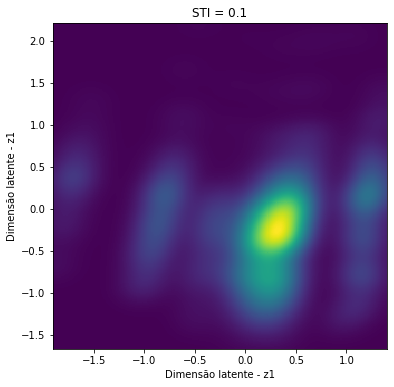

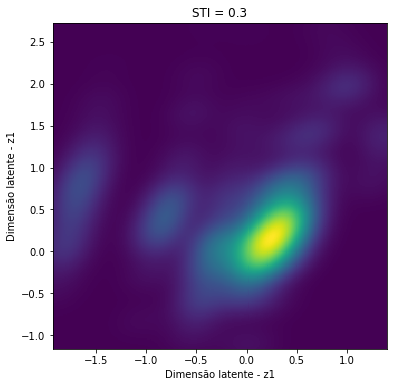

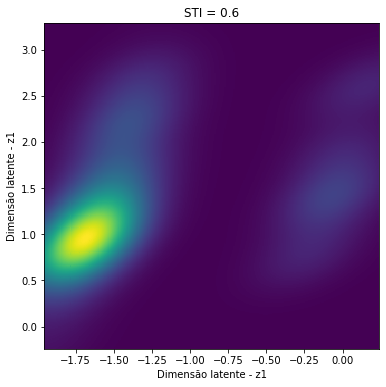

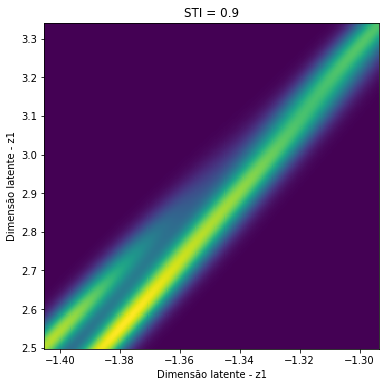

In [48]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import kde
 
######## create data
plt.figure(figsize=(6, 6))
is_STI_1 =  dataset['STI'] == 1
is_STI_1_data = dataset[is_STI_1]

x = is_STI_1_data['z1']
y = is_STI_1_data['z2']
 
# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
nbins=300
k = kde.gaussian_kde([x,y])
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
 
# Make the plot
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto')

plt.xlabel('Dimensão latente - z1')
plt.ylabel('Dimensão latente - z1')
plt.title('STI = 0.1')
plt.show()

######## create data
plt.figure(figsize=(6, 6))
is_STI_1 =  dataset['STI'] == 3
is_STI_1_data = dataset[is_STI_1]

x = is_STI_1_data['z1']
y = is_STI_1_data['z2']
 
# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
nbins=300
k = kde.gaussian_kde([x,y])
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
 
# Make the plot
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto')

plt.xlabel('Dimensão latente - z1')
plt.ylabel('Dimensão latente - z1')
plt.title('STI = 0.3')
plt.show()

######## create data
plt.figure(figsize=(6, 6))
is_STI_1 =  dataset['STI'] == 6
is_STI_1_data = dataset[is_STI_1]

x = is_STI_1_data['z1']
y = is_STI_1_data['z2']
 
# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
nbins=300
k = kde.gaussian_kde([x,y])
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
 
# Make the plot
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto')

plt.xlabel('Dimensão latente - z1')
plt.ylabel('Dimensão latente - z1')
plt.title('STI = 0.6')
plt.show()
#
######## create data
plt.figure(figsize=(6, 6))
is_STI_1 =  dataset['STI'] == 9
is_STI_1_data = dataset[is_STI_1]

x = is_STI_1_data['z1']
y = is_STI_1_data['z2']
 
# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
nbins=300
k = kde.gaussian_kde([x,y])
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
 
# Make the plot
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto')

plt.xlabel('Dimensão latente - z1')
plt.ylabel('Dimensão latente - z1')
plt.title('STI = 0.9')
plt.show()

# Change color palette
#plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto', cmap=plt.cm.Greens_r)
#plt.show()

# 10 - KCPR e outros métodos de regressão multivariada 
### 10 - KCPR and Other Multivariate Regression Methods  
#### Ridge Regression, PCR, KCPR, and PLSR: Multivariate Regression Methods

## 10.1 - Rigde Regression

In [49]:
from numpy import arange
from pandas import read_csv
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Ridge

# load the dataset
X, y = dataset[['z1','z2']].values, dataset['STI'].values

# define model
model = Ridge()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# define grid
grid = dict()
grid['alpha'] = arange(0, 1, 0.01)

# define search
search = GridSearchCV(model, grid, 
                      scoring='neg_mean_absolute_error', 
                      cv=cv, 
                      n_jobs=-1)

# perform the search
results = search.fit(X, y)
# summarize
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

MAE: -0.849
Config: {'alpha': 0.0}


## 10.2 - PCR - KCPR - PLSR

In [50]:
# Since we are using unbalaced data (STI values), we must first balance out the data
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
over_sampler = RandomOverSampler(random_state=42)
X_res, y_res = over_sampler.fit_resample(X, y)

print(f"Training target statistics: {Counter(y_res)}")
print(f"Testing target statistics: {Counter(y_test)}")

Training target statistics: Counter({1: 6954, 2: 6954, 4: 6954, 3: 6954, 6: 6954, 0: 6954, 5: 6954, 8: 6954, 7: 6954, 9: 6954})
Testing target statistics: Counter({2: 1407, 1: 1356, 3: 868, 0: 706, 4: 386, 5: 153, 6: 73, 7: 31, 8: 12, 9: 7})


## 10.3 - Comparação e Benchmarking de Modelos de Regressão Multivariada
#### 10.3 - Comparison and Benchmarking of Multivariate Regression Models

Training target statistics: Counter({1: 6954, 2: 6954, 4: 6954, 3: 6954, 6: 6954, 0: 6954, 5: 6954, 8: 6954, 7: 6954, 9: 6954})
Testing target statistics: Counter({2: 1407, 1: 1356, 3: 868, 0: 706, 4: 386, 5: 153, 6: 73, 7: 31, 8: 12, 9: 7})


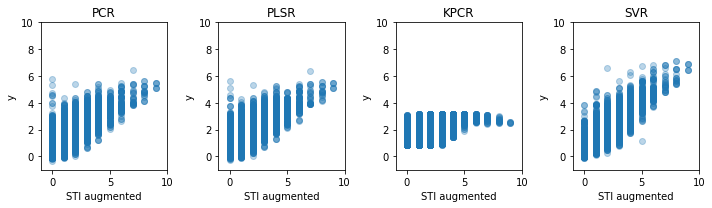

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import KernelPCA 

from imblearn.over_sampling import RandomOverSampler
from collections import Counter
over_sampler = RandomOverSampler(random_state=42)

X, y = dataset[['z1','z2']].values, dataset['STI'].values
X_res, y_res = over_sampler.fit_resample(X, y)

print(f"Training target statistics: {Counter(y_res)}")
print(f"Testing target statistics: {Counter(y_test)}")

# X, y = dataset[['z1','z2']].values, dataset['STI'].values

X_train, X_test, y_train, y_test = train_test_split(X, y)


pcr = make_pipeline(StandardScaler(), 
                    PCA(n_components=2), 
                    LinearRegression())

pcr.fit(X_train, y_train)

pca = pcr.named_steps["pca"]  # retrieve the PCA step of the pipeline

kpcr = make_pipeline(StandardScaler(), 
                     KernelPCA(kernel="rbf", n_components=2),
                     LinearRegression()
                    )

kpcr.fit(X_train, y_train)
# kpca = kpcr.named_steps["KernelPCA"]  # retrieve the PCA step of the pipeline

pls = PLSRegression(n_components=1)
pls.fit(X_train, y_train)

svr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
svr.fit(X_train, y_train)

fig, axes = plt.subplots(1, 4, figsize=(10, 3))

axes[0].scatter(
    y_test, pcr.predict(X_test), alpha=0.3, label="predictions"
)
axes[0].set(xlabel="STI augmented", ylabel="y", title="PCR")

axes[1].scatter(
    y_test, pls.predict(X_test), alpha=0.3, label="predictions"
)

axes[1].set(xlabel="STI augmented", ylabel="y", title="PLSR")

axes[2].scatter(
    y_test, kpcr.predict(X_test), alpha=0.3, label="predictions"
)
axes[2].set(xlabel="STI augmented", ylabel="y", title="KPCR")

axes[3].scatter(
    y_test, svr.predict(X_test), alpha=0.3, label="predictions"
)
axes[3].set(xlabel="STI augmented", ylabel="y", title="SVR")

for ax in axes.flat: #this will iterate over all 6 axes
    ax.set_xlim(-1, 10)
    ax.set_ylim(-1, 10) 
    
plt.tight_layout()
plt.show()

## 10.4 - Modelagem da Regressão de Kernel (KCPR)
## 10.4 - KCPR Modeling

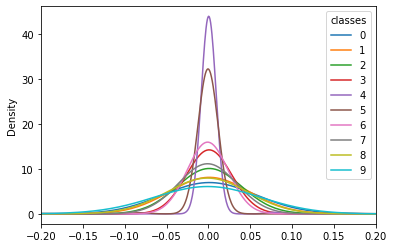

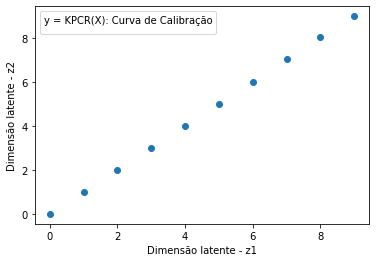

5.0

In [52]:
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, DotProduct
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy import linalg as LA

# https://web.mit.edu/modernml/course/lectures/MLClassLecture3.pdf (Pag. 5)
# kernel = RBF()
# RBF_KERNEL = kernel.__call__(X)
# kernel = ConstantKernel()
# kernel.__call__(X)
# kernel = DotProduct()
# kernel.__call__(X)

# Load the dataset
df_KPCR  = pd.read_csv('/kaggle/input/sti-prediction/dataset_high_z_dim_to_KCPR.csv')
df_KPCR.dropna(inplace=True)

# center the values in each column of the DataFrame
# X = df[['z1','z2']].values
# y = df['STI'].values

df_KPCR = df_KPCR.groupby(by=["classes"], dropna=True).mean()
df_KPCR = df_KPCR.drop(columns=["Unnamed: 0"])

# Mean centraing 
df_KPCR = df_KPCR.apply(lambda x: x-x.mean())

X_KPCR = df_KPCR.values
y_KPCR = df_KPCR.index.values

ax = df_KPCR.T.plot.kde(bw_method=0.3)
ax.set_xlim([-.2, 0.2])
plt.show()

y_KPCR
X_KPCR.shape
X_KPCR

# Get the kernel and calculte the respective transformation
kernel = RBF(0.2)
K = kernel.__call__(X_KPCR)

# centralize the kenerl
'''
N = K.shape[0]
one_n = np.ones((N,N)) / N
K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n) 
'''

# Verify if the kernel is centralized by the mean
# print(K.mean(axis=1))

# Calcuting the eigedecompostion
# eigenValues, eigenVectors = LA.eig(np.transpose(K) * K)
eigenValues, eigenVectors = LA.eig(K)

# Verirify if the kernel othornomal
# abs(eigenVectors)

Z = K  * eigenVectors
# Z = K  * abs(eigenVectors)

gamma = LA.inv(np.transpose(Z) * Z) * np.transpose(Z) * y_KPCR
y_pred = np.diag(Z*gamma)

plt.scatter(y_KPCR, y_pred)
plt.xlabel('Dimensão latente - z1')
plt.ylabel('Dimensão latente - z2')
plt.legend(title="y = KPCR(X): Curva de Calibração")
plt.show()
plt.show()

#M aking the model to predict function
# https://web.mit.edu/modernml/course/lectures/MLClassLecture3.pdf

x_hat = X_KPCR[5]
y_hat = (np.transpose(np.expand_dims(y_KPCR, 1)) *  K \
         * kernel.__call__(X_KPCR, np.transpose(np.expand_dims(x_hat, 1)))).max()
y_hat

## 10.5 - Persistência do modelo KCPR e SVR para ser usada como uma função de perda personalizada no modelo MVPAnP
#### 10.5 - KCPR and SVR Model persistence to be used as a custom loss function in the model MVPAnP Model

In [53]:
from joblib import dump, load
dump(svr, 'srv_reg.joblib') 

svr_persited  = load('srv_reg.joblib') 

svr_persited.predict(X_res[0:1])

array([0.40537054])

# 11 - Metodologia de Transferência de Aprendizagem
### 11 - Transfer Learning Methodology

## 11.1 - Carregar os dados do domínio de destino
#### 11.1 - Load the Target Domain Data

keras version  2.4.3

--- Load, inspect and transform data ---

Load data set from the npz
Number of columns in the dataframe: 5
Number of rows in the dataframe: 481401

First 20 rows of the dataframe:

    Room-id  STI  Freq - [Hz]  PSD(RIR)  PSD(BGN)
0       1.0    9          0.0    -225.3     -51.1
1       1.0    9         10.0    -224.1     -49.4
2       1.0    9         20.0    -223.2     -48.2
3       1.0    9         30.0    -222.4     -47.2
4       1.0    9         40.0    -221.8     -46.5
5       1.0    9         50.0    -221.2     -45.8
6       1.0    9         60.0    -220.7     -45.2
7       1.0    9         70.0    -220.2     -44.7
8       1.0    9         80.0    -219.8     -44.3
9       1.0    9         90.0    -218.7     -44.1
10      1.0    9        100.0    -217.0     -44.4
11      1.0    9        110.0    -215.7     -44.8
12      1.0    9        120.0    -214.8     -45.1
13      1.0    9        130.0    -214.0     -45.5
14      1.0    9        140.0    -213.3     -45

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



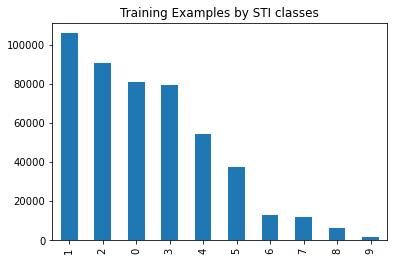

In [54]:
## Loader function of test/validation dataset for transfer learning

# Load data
A = np.load('../input/sti-prediction/data_to_transfer_02_11_22.npz')
A.files
A = A['arr_0']
df = pd.DataFrame({'c1': A[:,0], 'c2': A[:,1], 'c3': A[:,2], \
                   'c4': A[:,3], 'c5': A[:,4]})

"""## 2 - Functions settings
"""

def feature_normalize(dataset):

    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset - mu)/sigma


def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap="coolwarm",
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt="d")
    
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()


def show_basic_dataframe_info(dataframe,
                              preview_rows=20):

    """
    This function shows basic information for the given dataframe
    Args:
        dataframe: A Pandas DataFrame expected to contain data
        preview_rows: An integer value of how many rows to preview
    Returns:
        Nothing
    """

    # Shape and how many rows and columns
    print("Number of columns in the dataframe: %i" % (dataframe.shape[1]))
    print("Number of rows in the dataframe: %i\n" % (dataframe.shape[0]))
    print("First 20 rows of the dataframe:\n")
    # Show first 20 rows
    print(dataframe.head(preview_rows))
    print("\nDescription of dataframe:\n")
    # Describe dataset like mean, min, max, etc.
    # print(dataframe.describe())


def read_data(file_path):

    """
    This function reads the data from a file
    Args:
        file_path: URL pointing to the pickle file
    Returns:
        A pandas dataframe
    """

    df.rename(columns = {'c1': 'Room-id', 'c2': 'STI', 
                         'c3': 'Freq - [Hz]', 'c4': 'PSD(RIR)', 
                         'c5': 'PSD(BGN)' },  inplace = True)
   
    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
    
    label_encoder = LabelEncoder()
    n_bins = 10 # number of classes

   # 10 number of classes accoring to the STI range (0,1)
    y = label_encoder.fit_transform(pd.cut(df['STI'], n_bins, retbins=True)[0])

    df['STI'] = y   
    df.dropna(axis=0, how='any', inplace=True)

    return df


def convert_to_float(x):

    try:
        return np.float(x)
    except:
        return np.nan


# Not used right now
def feature_normalize(dataset):

    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset - mu)/sigma


def plot_axis(ax, x, y, title):

    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)


def plot_activity(activity, data):

    fig, (ax0, ax1) = plt.subplots(nrows=2,
         figsize=(15, 10),
         sharex=True)
    plot_axis(ax0, data['Freq - [Hz]'], data['PSD(RIR)'], 'PSD(RIR)')
    plot_axis(ax1, data['Freq - [Hz]'], data['PSD(BGN)'], 'PSD(BGN)')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    #plt.show()


def create_segments_and_labels(df, time_steps, step, label_name):

    """
    This function receives a dataframe and returns the reshaped segments
    of BGN, RIR data as well as the corresponding STI labels
    Args:
        df: Dataframe in the expected format
        time_steps: Integer value of the length of a segment that is created
    Returns:
        reshaped_segments
        labels:
    """

    N_FEATURES = 2
    
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    
    segments = []
    labels = []
    
    for i in range(0, len(df) - time_steps, step):
        xs = df['PSD(RIR)'].values[i: i + time_steps]
        ys = df['PSD(BGN)'].values[i: i + time_steps]
        xs = xs[1:]
        ys = ys[1:]
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([xs, ys])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32) \
                          .reshape(-1, time_steps-1, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

"""

## Create training database
"""

# Set some standard parameters upfront
pd.options.display.float_format = '{:.1f}'.format
# sns.set() # Default seaborn look and feel
# plt.style.use('ggplot')
print('keras version ', keras.__version__)

LABELS = ["1","2","3","4","5","6 ","7","8","9","10"]

# The number of steps within one time segment
TIME_PERIODS = len(np.arange(0,8001,10))
STEP_DISTANCE = TIME_PERIODS

print("\n--- Load, inspect and transform data ---\n")

print("Load data set from the npz")
read_data(df)
# Describe the data
show_basic_dataframe_info(df, 20)

# Total number of rooms
print("\n--- Calculating total number of classrooms ---\n")
num_rooms = len(df) / TIME_PERIODS

df['STI'].value_counts().plot(kind='bar', title='Training Examples by STI classes')
plt.savefig('STI_distribution_target_domain.pdf')
#plt.show()

print("\n--- Reshape the data into segments ---\n")

# Differentiate between test set and training set
df_train = df[df['Room-id'] <= 0.7* num_rooms]
df_test = df[df['Room-id'] > 0.7* num_rooms]

# Normalize features for training data set
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
column_names_to_normalize = ['PSD(RIR)',  'PSD(BGN)']

x = df_train[column_names_to_normalize].values
x_scaled = scaler.fit_transform(x)

df_temp = pd.DataFrame(x_scaled, 
                       columns=column_names_to_normalize, 
                       index = df_train.index)
df_train[column_names_to_normalize] = df_temp

# Test dataset
x = df_test[column_names_to_normalize].values
x_scaled = scaler.fit_transform(x)

df_temp = pd.DataFrame(x_scaled, 
                       columns=column_names_to_normalize, 
                       index = df_test.index)

df_test[column_names_to_normalize] = df_temp

# Round in order to comply to NSNumber
df_train = df_train.round({'PSD(RIR)': 6, 'PSD(BGN)': 6})
df_test =  df_test.round({'PSD(RIR)': 6, 'PSD(BGN)': 6})

# Reshape the training data into segments, so that they can be processed by 
# the network
# Define column name of the label vector

LABEL = "STI"
x_train, y_train = create_segments_and_labels(df_train,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)

x_test, y_test = create_segments_and_labels(df_test,
                                            TIME_PERIODS,
                                            STEP_DISTANCE,
                                            LABEL)

In [55]:

print("\n--- Reshape data to be accepted by Keras ---\n")

# Inspect x data
print('x_train shape: ', x_train.shape)
print(x_train.shape[0], 'training samples')

# Inspect y data
print('y_train shape: ', y_train.shape)

print('y_test shape: ', y_test.shape)

# Set input_shape / reshape for Keras

print(" Verifying the trainign dataset dimensions")

print("Dimensoes antes")
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

# Input image dimensions
img_rows = 1600  
# len(np.arange(0,8001,10)) aproximação 800 TR and 800 TO BGN

# Channels go last for TensorFlow backend
print("Dimensão após restruturacao - treino")
x_train_reshaped = x_train.reshape(x_train.shape[0], img_rows)
print(x_train_reshaped.shape)

# Agora fazer o teste
print("Dimensão após restruturacao - teste")
x_test_reshaped = x_test.reshape(x_test.shape[0], img_rows)
print(x_test_reshaped.shape)

x_tr = x_train_reshaped
x_te = x_test_reshaped


--- Reshape data to be accepted by Keras ---

x_train shape:  (420, 800, 2)
420 training samples
y_train shape:  (420,)
y_test shape:  (179,)
 Verifying the trainign dataset dimensions
Dimensoes antes
x_train shape: (420, 800, 2)
x_test shape: (179, 800, 2)
Dimensão após restruturacao - treino
(420, 1600)
Dimensão após restruturacao - teste
(179, 1600)


## 11.2 - Estatísticas de distribuição de dados do domínio de destino
## 11.2 - Target Domain Data Distribution Statistics

0.24043261231281193 0.19343418663823914


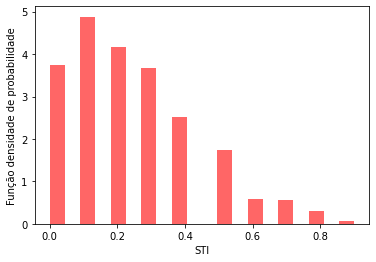

In [56]:
### Fitting 
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

# Extract the column from the dataframe and convert it to a numpy array
data = (df['STI']/10).values

# Fit a Gaussian distribution to the data
mu, std = stats.norm.fit(data)

# Plot the histogram
plt.hist(data, bins=20, density=True, alpha=0.6, color='r')

# Add a title and labels
plt.xlabel('STI')
plt.ylabel('Função densidade de probabilidade')

# Show the plot
print(mu, std)

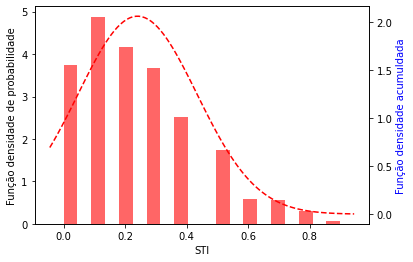

0.24043261231281193 0.19343418663823914


In [57]:
# Plot the histogram
plt.hist(data, bins=20, density=True, alpha=0.6, color='r')

# Plot the Gaussian fit
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)

# plt.plot(x, c, 'r', linewidth=2)
# Add a title and labels
plt.xlabel('STI')
plt.ylabel('Função densidade de probabilidade')

ax2 = plt.twinx()

# plot the data for the second y-axis
ax2.plot(x, p, 'r--')
ax2.set_ylabel('Função densidade acumuldada', color='b')

# show the plot
plt.show()


# Show the plot
print(mu, std)

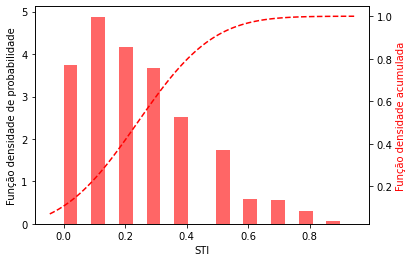

0.24043261231281193 0.19343418663823914


In [58]:
# Plot the histogram
plt.hist(data, bins=20, density=True, alpha=0.6, color='r')

# Plot the Gaussian fit
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
c = stats.norm.cdf(x, mu, std)

# plt.plot(x, c, 'r', linewidth=2)
# Add a title and labels
plt.xlabel('STI')
plt.ylabel('Função densidade de probabilidade')

ax2 = plt.twinx()

# plot the data for the second y-axis
ax2.plot(x, c, 'r--')
ax2.set_ylabel('Função densidade acumulada', color='r')

# show the plot
plt.show()


# Show the plot
print(mu, std)

2.40432612312812 1.9343418663823913


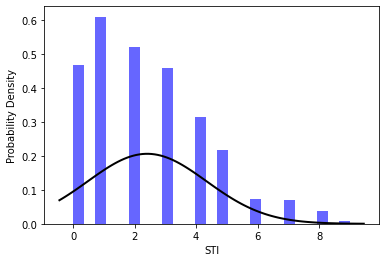

In [59]:
### Fitting 
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

# Extract the column from the dataframe and convert it to a numpy array
data = df['STI'].values

# Fit a Gaussian distribution to the data
mu, std = stats.norm.fit(data)

# Plot the histogram
plt.hist(data, bins=25, density=True, alpha=0.6, color='b')

# Plot the Gaussian fit
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

# Add a title and labels
plt.xlabel('STI')
plt.ylabel('Probability Density')

# Show the plot
print(mu, std)

In [60]:
x_tr.shape

(420, 1600)

In [61]:
y_train.shape

(420,)

# 12 - Reconstruindo o espaço latente VAE para o domínio de destino por meio do modelo de codificador treinado no domínio de origem
### 12 - Reconstructing the VAE Latent Space for the Target Domain via the Encoder Model Trained on the Source Domain

In [62]:
reconstructed_model = keras.models.load_model("vae_encoder.h5")

# x_tr_latent = encoder.predict(x_tr, batch_size=batch_size)
x_tr_latent = reconstructed_model.predict(x_tr, batch_size=1)
y_tr = y_train                            
dataset = pd.DataFrame({'z1': x_tr_latent[:, 0], 'z2': x_tr_latent[:, 1], 'STI':  y_tr})
print(dataset)

      z1   z2  STI
0    1.1 -1.2    9
1    0.2 -2.4    7
2    0.5 -2.0    3
3    0.5 -1.9    2
4   -0.1 -2.8    1
..   ...  ...  ...
415 -0.8 -0.1    1
416 -0.8 -0.0    1
417 -0.7  0.5    1
418 -0.8  0.2    0
419 -0.7  0.8    3

[420 rows x 3 columns]


# 12.1 - Plotando a representação do espaço latente (z = 2) dos dados de teste no conjunto de dados de destino
### 12.1 - Plotting the Latent Space Representation (z = 2) of the Testing Data in the Target Dataset

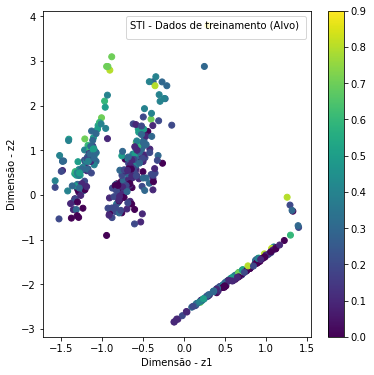

In [63]:
# Latent Space obtined from the target domain
# Plot the target domain (target)

plt.figure(figsize=(6, 6))
y_tr = y_train
plt.scatter(x_tr_latent[:, 0], x_tr_latent[:, 1], c=y_tr/10)
plt.colorbar()

plt.legend(title="STI - Dados de treinamento (Alvo) ")
plt.xlabel('Dimensão - z1')
plt.ylabel('Dimensão - z2')
#ax.add_artist(legend1)

plt.show()

### 12.1.1 - Visualização da Estimativa de Densidade do Kernel (KDE) para o Domínio de Destino
##### 12.1.1 - Visualization of Kernel Density Estimation (KDE) for the Target Domain

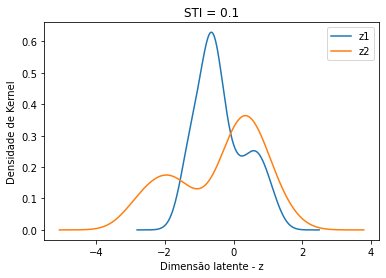

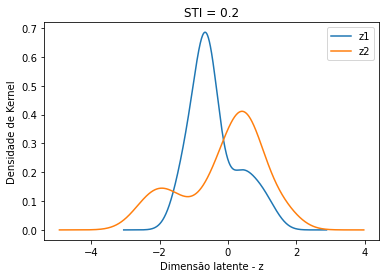

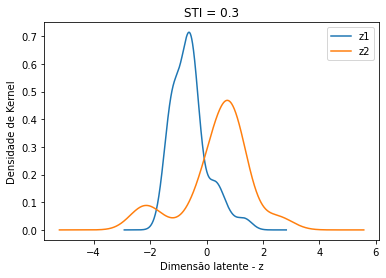

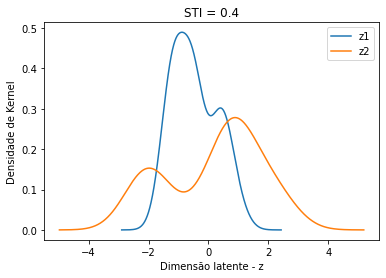

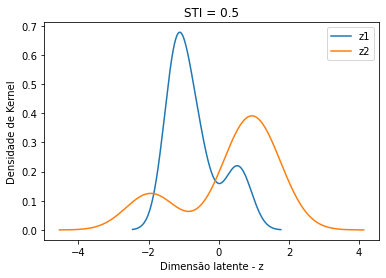

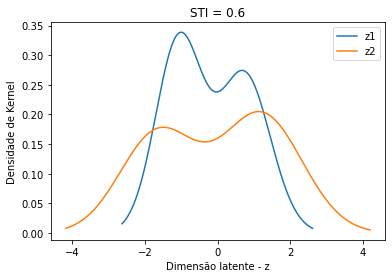

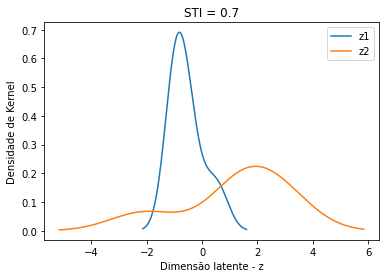

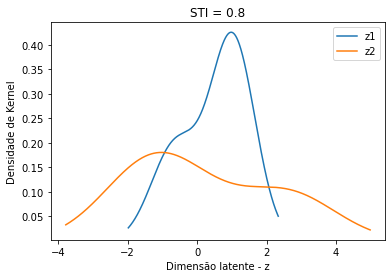

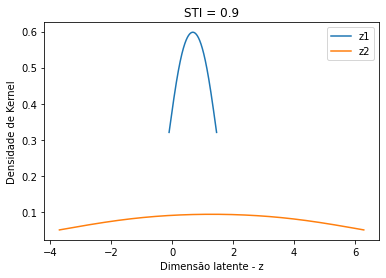

In [64]:
###
is_STI_1 =  dataset['STI'] == 1
is_STI_1_data = dataset[is_STI_1]
#print(is_STI_1_data)
is_STI_1_data = is_STI_1_data[['z1','z2']]
ax = is_STI_1_data.plot.kde()
plt.xlabel('Dimensão latente - z')
plt.ylabel('Densidade de Kernel')
plt.title('STI = 0.1')
plt.show()
###
###
is_STI_1 =  dataset['STI'] == 2
is_STI_1_data = dataset[is_STI_1]
#print(is_STI_1_data)
is_STI_1_data = is_STI_1_data[['z1','z2']]
ax = is_STI_1_data.plot.kde()
plt.xlabel('Dimensão latente - z')
plt.ylabel('Densidade de Kernel')
plt.title('STI = 0.2')
plt.show()
###
is_STI_1 =  dataset['STI'] == 3
is_STI_1_data = dataset[is_STI_1]
#print(is_STI_1_data)
is_STI_1_data = is_STI_1_data[['z1','z2']]
ax = is_STI_1_data.plot.kde()
plt.xlabel('Dimensão latente - z')
plt.ylabel('Densidade de Kernel')
plt.title('STI = 0.3')
plt.show()
###
is_STI_1 =  dataset['STI'] == 4
is_STI_1_data = dataset[is_STI_1]
#print(is_STI_1_data)
is_STI_1_data = is_STI_1_data[['z1','z2']]
ax = is_STI_1_data.plot.kde()
plt.xlabel('Dimensão latente - z')
plt.ylabel('Densidade de Kernel')
plt.title('STI = 0.4')
plt.show()
####
is_STI_1 =  dataset['STI'] == 5
is_STI_1_data = dataset[is_STI_1]
#print(is_STI_1_data)
is_STI_1_data = is_STI_1_data[['z1','z2']]
ax = is_STI_1_data.plot.kde()
plt.xlabel('Dimensão latente - z')
plt.ylabel('Densidade de Kernel')
plt.title('STI = 0.5')
plt.show()
####
is_STI_1 =  dataset['STI'] == 6
is_STI_1_data = dataset[is_STI_1]
#print(is_STI_1_data)
is_STI_1_data = is_STI_1_data[['z1','z2']]
ax = is_STI_1_data.plot.kde()
plt.xlabel('Dimensão latente - z')
plt.ylabel('Densidade de Kernel')
plt.title('STI = 0.6')
plt.show()
####
is_STI_1 =  dataset['STI'] == 7
is_STI_1_data = dataset[is_STI_1]
#print(is_STI_1_data)
is_STI_1_data = is_STI_1_data[['z1','z2']]
ax = is_STI_1_data.plot.kde()
plt.xlabel('Dimensão latente - z')
plt.ylabel('Densidade de Kernel')
plt.title('STI = 0.7')
plt.show()
####
is_STI_1 =  dataset['STI'] == 8
is_STI_1_data = dataset[is_STI_1]
#print(is_STI_1_data)
is_STI_1_data = is_STI_1_data[['z1','z2']]
ax = is_STI_1_data.plot.kde()
plt.xlabel('Dimensão latente - z')
plt.ylabel('Densidade de Kernel')
plt.title('STI = 0.8')
plt.show()
####
is_STI_1 =  dataset['STI'] == 9
is_STI_1_data = dataset[is_STI_1]
#print(is_STI_1_data)
is_STI_1_data = is_STI_1_data[['z1','z2']]
ax = is_STI_1_data.plot.kde()
plt.xlabel('Dimensão latente - z')
plt.ylabel('Densidade de Kernel')
plt.title('STI = 0.9')
plt.show()

### 12.1.1.1 - MAPEAMENTO DOS DADOS DE ALVO (MMD - Target Domain)

In [65]:
z_mapping_VAE_target_domain = dataset
z_mapping_VAE_target_domain

,z1,z2,STI
0,1.1,-1.2,9
1,0.2,-2.4,7
2,0.5,-2.0,3
3,0.5,-1.9,2
4,-0.1,-2.8,1
...,...,...,...
415,-0.8,-0.1,1
416,-0.8,-0.0,1
417,-0.7,0.5,1
418,-0.8,0.2,0


#### 12.1.2 - KDE 2D Visualization of the bidmensional encoded space and STI values (Target Domain)

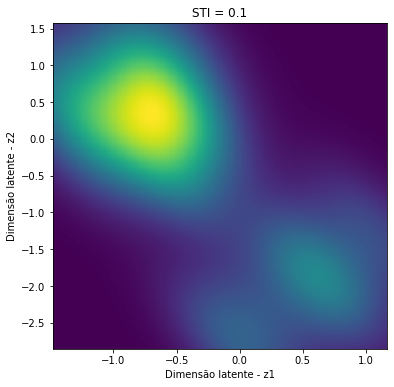

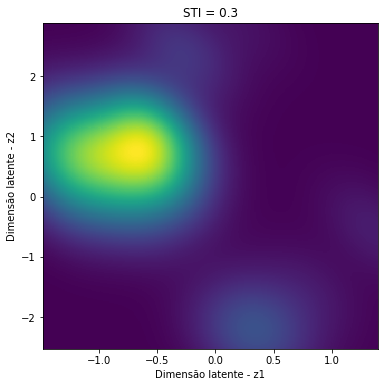

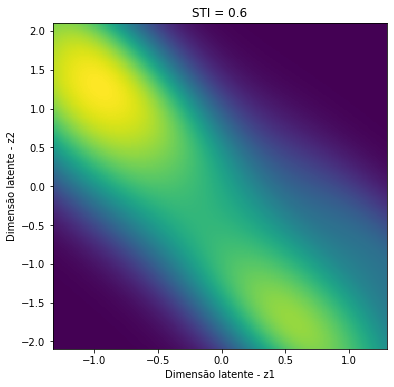

"\nplt.figure(figsize=(6, 6))\nis_STI_1 =  dataset['STI'] == 9\nis_STI_1_data = dataset[is_STI_1]\n\nx = is_STI_1_data['z1']\ny = is_STI_1_data['z2']\n \n# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents\nnbins=300\nk = kde.gaussian_kde([x,y])\nxi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]\nzi = k(np.vstack([xi.flatten(), yi.flatten()]))\n \n# Make the plot\nplt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto')\n\nplt.xlabel('Dimensão latente - z1')\nplt.ylabel('Dimensão latente - z2')\nplt.title('STI = 0.9')\nplt.show()\n"

In [66]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import kde
 
######## create data
plt.figure(figsize=(6, 6))
is_STI_1 =  dataset['STI'] == 1
is_STI_1_data = dataset[is_STI_1]

x = is_STI_1_data['z1']
y = is_STI_1_data['z2']
 
# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
nbins=300
k = kde.gaussian_kde([x,y])
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
 
# Make the plot
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto')

plt.xlabel('Dimensão latente - z1')
plt.ylabel('Dimensão latente - z2')
plt.title('STI = 0.1')
plt.show()
#####
######## create data
plt.figure(figsize=(6, 6))
is_STI_1 =  dataset['STI'] == 3
is_STI_1_data = dataset[is_STI_1]

x = is_STI_1_data['z1']
y = is_STI_1_data['z2']
 
# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
nbins=300
k = kde.gaussian_kde([x,y])
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
 
# Make the plot
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto')

plt.xlabel('Dimensão latente - z1')
plt.ylabel('Dimensão latente - z2')
plt.title('STI = 0.3')
plt.show()
#####
######## create data
plt.figure(figsize=(6, 6))
is_STI_1 =  dataset['STI'] == 6
is_STI_1_data = dataset[is_STI_1]

x = is_STI_1_data['z1']
y = is_STI_1_data['z2']
 
# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
nbins=300
k = kde.gaussian_kde([x,y])
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
 
# Make the plot
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto')

plt.xlabel('Dimensão latente - z1')
plt.ylabel('Dimensão latente - z2')
plt.title('STI = 0.6')
plt.show()

######## create data
'''
plt.figure(figsize=(6, 6))
is_STI_1 =  dataset['STI'] == 9
is_STI_1_data = dataset[is_STI_1]

x = is_STI_1_data['z1']
y = is_STI_1_data['z2']
 
# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
nbins=300
k = kde.gaussian_kde([x,y])
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
 
# Make the plot
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto')

plt.xlabel('Dimensão latente - z1')
plt.ylabel('Dimensão latente - z2')
plt.title('STI = 0.9')
plt.show()
'''

# 12.2 - Cálculo da métrica MMD e visualização
### 12.2 - MMD metric calculation and visualization of the Maximum Mean Discrepancy (MMD)

MMD result of X and Y is 0.3414015471935272


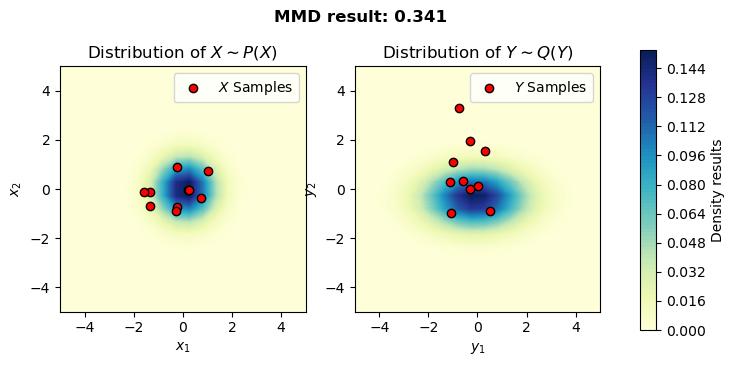

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.stats import dirichlet
from torch.distributions.multivariate_normal import MultivariateNormal

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

m = 20 # sample size, a smal number for the opimzation

x_mean = torch.FloatTensor(([z_mapping_VAE_source_domain["z1"].mean(),
               z_mapping_VAE_source_domain["z2"].mean()])) 

#t orch.zeros(2) + 1 #(pegue as médias z1 e z2 form Source)

y_mean = torch.FloatTensor(([z_mapping_VAE_target_domain["z1"].mean(),
               z_mapping_VAE_target_domain["z2"].mean()])) 

#torch.zeros(2)     #(pegue as médias z1 e z2 form Target)

# I can calculate the both
x_cov =  torch.FloatTensor(
                           np.cov([z_mapping_VAE_source_domain["z1"], 
                                  z_mapping_VAE_source_domain["z2"]])
                                  ) * torch.eye(2) #2*torch.eye(2) 
                          
# IMPORTANT: Covariance matrices must be positive definite
y_cov = torch.FloatTensor(
                          np.cov([z_mapping_VAE_target_domain["z1"], 
                                 z_mapping_VAE_target_domain["z2"]])
                                 ) * torch.eye(2)

# Making the sampling
px = MultivariateNormal(x_mean, x_cov)
qy = MultivariateNormal(y_mean, y_cov)

x = px.sample([m]).to(device)
y = qy.sample([m]).to(device)


def MMD(x, y, kernel):
    """Emprical maximum mean discrepancy. The lower the result
       the more evidence that distributions are the same.

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        kernel: kernel type such as "multiscale" or "rbf"
    """
    xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()),torch.mm(x, y.t())
            
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))
   
    dxx = rx.t() + rx - 2. * xx 
    dyy = ry.t() + ry - 2. * yy 
    dxy = rx.t() + ry - 2. * zz
   
    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))
   
    if kernel == "multiscale":
       
        bandwidth_range = [0.2, 0.5, 0.9, 1.3]
        for a in bandwidth_range:
            XX += a**2 * (a**2 + dxx)**-1
            YY += a**2 * (a**2 + dyy)**-1
            XY += a**2 * (a**2 + dxy)**-1
           
    if kernel == "rbf":
     
        bandwidth_range = [10, 15, 20, 50]
        for a in bandwidth_range:
            XX += torch.exp(-0.5*dxx/a)
            YY += torch.exp(-0.5*dyy/a)
            XY += torch.exp(-0.5*dxy/a)
     
    return torch.mean(XX + YY - 2. * XY)


result = MMD(x, y, kernel="multiscale")

print(f"MMD result of X and Y is {result.item()}")

# ---- Plotting setup ----

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,4), dpi=100)
# plt.tight_layout()
delta = 0.025

x1_val = np.linspace(-5, 5, num=m)
x2_val = np.linspace(-5, 5, num=m)

x1, x2 = np.meshgrid(x1_val, x2_val)

px_grid = torch.zeros(m,m)
qy_grid = torch.zeros(m,m)

for i in range(m):
    for j in range(m):
        px_grid[i,j] = multivariate_normal.pdf([x1_val[i],x2_val[j]], 
                                               x_mean, 
                                               x_cov)
        
        qy_grid[i,j] = multivariate_normal.pdf([x1_val[i],x2_val[j]], 
                                               y_mean, 
                                               y_cov)


CS1 = ax1.contourf(x1, x2, px_grid,100, cmap=plt.cm.YlGnBu)
ax1.set_title("Distribution of $X \sim P(X)$")
ax1.set_ylabel('$x_2$')
ax1.set_xlabel('$x_1$')
ax1.set_aspect('equal')
ax1.scatter(x[:10,0].cpu(), x[:10,1].cpu(), 
            label="$X$ Samples", 
            marker="o", 
            facecolor="r", 
            edgecolor="k")

ax1.legend()

CS2 = ax2.contourf(x1, x2, qy_grid,100, cmap=plt.cm.YlGnBu)
ax2.set_title("Distribution of $Y \sim Q(Y)$")
ax2.set_xlabel('$y_1$')
ax2.set_ylabel('$y_2$')
ax2.set_aspect('equal')
ax2.scatter(y[:10,0].cpu(), y[:10,1].cpu(), 
            label="$Y$ Samples", 
            marker="o", 
            facecolor="r", 
            edgecolor="k")
ax2.legend()

# ax1.axis([-2.5, 2.5, -2.5, 2.5])

# Add colorbar and title
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(CS2, cax=cbar_ax)
cbar.ax.set_ylabel('Density results')
plt.suptitle(f"MMD result: {round(result.item(),3)}",
             y=0.95, 
             fontweight="bold")

plt.show()

## 12.3 - Previsão em lote para o conjunto de dados x_tr
#### 12.3 - Batch Prediction for the x_tr Dataset

In [68]:
print(x_tr[0].shape)
x_tr_latent = encoder.predict(x_tr, batch_size=batch_size)

# This result is gonna be the reference value for the Loss function
svr.predict(x_tr_latent)
print("This was the batch prediction")

(1600,)
This was the batch prediction


## 12.4 - Previsão de amostra única no domínio de destino usando o modelo de codificador treinado no domínio de origem
#### 12.4 - Single Sample Prediction in the Target Domain Using the Encoder Model Trained on the Source Domain

In [69]:
print(x_tr[0:2].shape)

x_tr_latent = encoder.predict(x_tr[0:2], batch_size=batch_size)
x_tr_latent

svr.predict(x_tr_latent)

(2, 1600)


array([ 0.24854597, -0.00749628])

## 12.5 - Validação de modelo: validação de dimensão
#### 12.5 - Model Validation: Dimension Validation

In [70]:
# No verifies the testing dataset
print("Input sinal bruto - Dimensão bruta antes de formatar:", x_test.shape)

print("Dimensão após restruturação para servir com a input do autoencoder:", 
      x_test.reshape(x_test.shape[0], 
      img_rows).shape)

x_test_reshaped = x_test.reshape(x_test.shape[0], img_rows)

# configura input do autoencoder (batch )
x_input_vae = x_test_reshaped

print("Fazendo uma predição no VAE para obter o espaço amostral: ",
    np.expand_dims(x_input_vae[2], axis=0).shape)

x_tr_latent_pred = encoder.predict(np.expand_dims(x_input_vae[5], axis=0),
                                   batch_size=batch_size)

# x_tr_latent = encoder.predict(x_input_vae[2:3], batch_size=batch_size)
x_tr_latent_pred

# Lembrar que tenho que fazer a padronização para predição 
# (padronização do input max, minx), já configurado.
svr.predict(x_tr_latent_pred)

Input sinal bruto - Dimensão bruta antes de formatar: (179, 800, 2)
Dimensão após restruturação para servir com a input do autoencoder: (179, 1600)
Fazendo uma predição no VAE para obter o espaço amostral:  (1, 1600)


array([0.05756736])

# 13 - Modelagem de aprendizagem de transferência
### 13 - Transfer Learning Modeling

In [71]:
import numpy as np
import keras
from keras.layers import Input
from keras.layers.core import Dense, Dropout, Activation
from keras.models import Sequential
from keras.utils import np_utils
from keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras import backend as K
import matplotlib.pyplot as plt
import tensorflow as tf

In [72]:
# verifiyng the shape
print(x_tr.shape)
print(y_train.shape)

(420, 1600)
(420,)


In [73]:
from sklearn.model_selection import train_test_split

### fix it
X_train, X_test, y_train, y_test = train_test_split(x_tr, 
                                                    y_train, 
                                                    test_size=0.1,
                                                    random_state=42)

In [74]:
print(X_train.shape)
print(y_train.shape)

(378, 1600)
(378,)


In [75]:
print(X_test.shape)
print(y_test.shape)

(42, 1600)
(42,)


In [76]:
# Balanced dataset
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
over_sampler = RandomOverSampler(random_state=42)

X_res, y_res = over_sampler.fit_resample(X_train, y_train)

print(f"Training target statistics: {Counter(y_res)}")
# print(f"Testing target statistics: {Counter(y_test)}")

Training target statistics: Counter({1: 72, 3: 72, 0: 72, 7: 72, 2: 72, 6: 72, 4: 72, 9: 72, 5: 72, 8: 72})


In [77]:
X_train, y_train = X_res, y_res/10

## 13.1 - Carga da função de perda KCPR usada na equação MVPanP
#### 13.1 - Loading the KCPR Loss Function Used in the MVPAnP Equation

In [78]:
# Load 
svr_persited  = load('srv_reg.joblib') 
svr.predict(x_tr_latent)

# Load vae
encoder_reconstruted = keras.models.load_model("my_model.model")

print(x_tr[0:1].shape)
print(type(x_tr[0:1]))
print(x_tr[0:1].dtype)

latent_pred = encoder_reconstruted.predict(x_tr[0:2], batch_size=1)
latent_pred

(1, 1600)
<class 'numpy.ndarray'>
float32


array([[ 1.0697757, -1.2002994],
       [ 0.1986655, -2.407274 ]], dtype=float32)

In [79]:
svr.predict([[1., 1.0]])

array([1.865033])

## 13.2 - Implementação da função KCPR Loss (Custom Tensor Function) no modelo Eager
#### 13.2 - Implementation of the KCPR Loss Function (Custom Tensor Function) in Eager Mode

In [80]:
# from numpy import linalg as LA
kl = tf.keras.losses.KLDivergence()

# Reconstruting the VAE model trained on the Source Domain 
encoder_reconstruted = keras.models.load_model("my_model.model")  

def KPCR_Prediction_Loss(input_tensor):
        
    z_latent = tensorflow_graph(np.expand_dims(input_tensor, axis=0),
                                False, None).numpy()
        
    src_pred = svr.predict(z_latent)
          
    return src_pred # np.sinh(input_tensor)

@tf.function(input_signature=[tf.TensorSpec(None, tf.float32)])
def KPCR_loss(input):
    
    
  y = tf.numpy_function(KPCR_Prediction_Loss, [input], tf.float32).numpy()

  return y

'''
def KPCR_loss(input_tensor):
    
    latent_pred = encoder_reconstruted.predict(
                                               input_tensor.numpy(), 
                                               batch_size=1)

    return 0 #svr_persited.predict(latent_pred) 
'''

def MVPAnP_Loss(data, y_pred):
    
    y_true = data[0][0]
    input2latent = data[0][1:1601]

    return K.mean(K.square(y_pred - y_true),
                  axis=-1) + 0.1* kl(KPCR_loss(input2latent),
                                     y_true)

# MVPAnP_Loss --> Loss function sum of components
# MVPAnP_Loss --> custom_loss2
# my_numpy_func --> KPCR_Prediction_Loss
# tf_function(data) # KPCR_loss(data )

## 13.3 - Criando um modelo simples de MLP (Multilayer Perceptron) para testar a função de perda personalizada
#### 13.3 - Creating a Simple MLP (Multilayer Perceptron) Model to Test the Custom Loss Function

In [81]:
# create model
tf.config.run_functions_eagerly(True)

i = Input(shape=(1600,))
x = Dense(50, kernel_initializer='glorot_uniform', activation='relu')(i)
x = Dense(50, activation='relu')(x)
x = Dense(25, activation='sigmoid')(x)
o = Dense(1, activation='sigmoid')(x)
#o = Dense(1, kernel_initializer='normal', activation='linear')(x)
model = Model(i, o)

model.compile(loss=MVPAnP_Loss, optimizer='adam') 

history = model.fit(X_train, np.column_stack((y_train, X_train)), 
                    epochs=5, 
                    batch_size=1,
                    verbose=0)

#model.fit(X_train, [X_train,y_train], epochs=1, batch_size=1,verbose=1)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning:

Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.



In [82]:
type(X_train)

numpy.ndarray

In [83]:
print(X_train.shape)
print(y_train.shape)

(720, 1600)
(720,)


In [84]:
data = np.column_stack((y_train, X_train))
data.shape

(720, 1601)

dict_keys(['loss'])


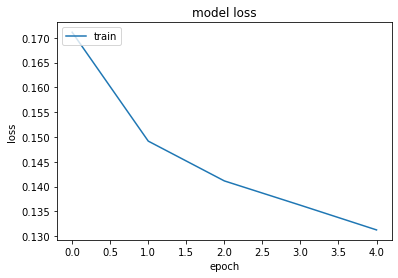

In [85]:
"""
history = model.fit(X_train, 
                    [X_train,y_train], 
                    epochs=1, 
                    batch_size=1,
                    verbose=0)
"""

# list all data in history
print(history.history.keys())

# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [86]:
# Evalute model
score = model.evaluate(X_train, np.column_stack((y_train, X_train)), verbose=1)
print('Test loss:', score)

11/23 [=============>................] - ETA: 0s - loss: 0.2368

/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning:

Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.



23/23 [==============================] - 0s 11ms/step - loss: 0.1399
Test loss: 0.13988247513771057


In [87]:
# Make a prediction
yhat = model.predict(X_train)
yhat.shape

/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning:

Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.



(720, 1)

In [88]:
y_train

array([0.1, 0.3, 0.3, 0. , 0. , 0.7, 0.2, 0.6, 0.4, 0.1, 0.9, 0.6, 0.2,
       0. , 0. , 0. , 0. , 0. , 0. , 0.1, 0.5, 0.1, 0.1, 0.1, 0.2, 0. ,
       0.1, 0.4, 0.5, 0.2, 0.5, 0. , 0.1, 0. , 0.1, 0.2, 0.2, 0. , 0.6,
       0.2, 0.1, 0.3, 0.5, 0.4, 0.2, 0.2, 0.1, 0.4, 0.4, 0.3, 0.3, 0.4,
       0.2, 0.2, 0. , 0.3, 0.1, 0.1, 0.3, 0.3, 0.3, 0.2, 0.4, 0.2, 0.8,
       0. , 0.4, 0.4, 0.2, 0.1, 0.2, 0.5, 0.2, 0.4, 0. , 0.3, 0.2, 0.8,
       0.6, 0.2, 0. , 0.1, 0.3, 0.3, 0.3, 0.4, 0.3, 0.7, 0.4, 0.4, 0.4,
       0.1, 0.3, 0.2, 0. , 0.2, 0.1, 0.3, 0.1, 0. , 0.3, 0.4, 0.6, 0.5,
       0. , 0.3, 0.1, 0. , 0.1, 0.5, 0.1, 0.1, 0.3, 0.4, 0.2, 0.3, 0. ,
       0.5, 0. , 0.6, 0.3, 0.2, 0.4, 0.3, 0. , 0.4, 0.8, 0.5, 0.5, 0.3,
       0.4, 0.5, 0.1, 0.4, 0.7, 0.2, 0.5, 0.3, 0.1, 0.3, 0.1, 0.1, 0.2,
       0.3, 0.1, 0.7, 0.1, 0. , 0.3, 0. , 0.3, 0.1, 0.2, 0.4, 0.3, 0.1,
       0. , 0. , 0.1, 0.1, 0.3, 0.1, 0.3, 0.1, 0.2, 0.5, 0.1, 0.1, 0.2,
       0.4, 0.3, 0.2, 0.3, 0.3, 0.2, 0. , 0.3, 0. , 0. , 0.3, 0.

## 13.4 - Validação do modelo MVPanP: usando otimização de hiperparâmetros e ANOVA
#### 13.4 - MVPAnP Model Validation: Using Hyperparameter Optimization and ANOVA

In [89]:
"""
Optuna example that optimizes a neural network 
classifier configuration for the
MNIST dataset using Keras.
In this example, we optimize the validation accuracy of 
MNIST classification using
Keras. We optimize the filter and kernel size, 
kernel stride and layer activation.
# reference: 
https://github.com/optuna/optuna-examples/blob/main/keras/keras_simple.py
"""
import urllib
import warnings

import optuna

from keras.backend import clear_session
from keras.datasets import mnist
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop

### 13.4.1 - Otimização de Hiperparâmetros para Modelo de Linha de Base (Rede Neural Convolucional 1D) sem Transfer Learning
##### 13.4.1 - Hyperparameter Optimization for Baseline Model (1D Convolutional Neural Network) without Transfer Learning

In [90]:
def start_Baseline(features1,features2, trials,  plot_graph = False):

  # 1D CONV NET MODEL
  def create_model(activation, 
                   dropout_rate, 
                   filters, 
                   kernel_size, 
                   strides, 
                   kernel_initializer):
    
    """
    Create an temporary model
    """
    clear_session()
    
    '''
    # 1D CNN neural network - 1D CNN model starts
    model_m.add(Reshape((TIME_PERIODS, num_sensors),
                         input_shape=(input_shape,)))
                         
    model_m.add(Conv1D(100, 10, activation='relu', 
                 input_shape=(TIME_PERIODS, 
                 num_sensors)))
                 
    i = Reshape((1600, 1), input_shape=(1600,))
    
    filters = num_filters[0]
    print("FILTER VALUES ----------" , filters)
    '''

    if type(filters) == tuple:
        filter_num = filters[0]
    else:
        filter_num = filters
        
    print("FILTER VALUES ----------" , filters)    
    print("FILTER VALUES ----------" , filter_num)
    
    i = Input(shape=(1600,1))
    #x = Conv1D(100, 10, kernel_initializer=kernel_initializer, 
    #activation=activation, input_shape=(1600, 1))(i)
    x = Conv1D(filters=filter_num, 
               kernel_size=kernel_size, 
               strides=strides, 
               kernel_initializer=kernel_initializer, 
               activation=activation,
               input_shape=(1600, 1))(i)
    #i = Input(shape=(1600,))
    x = Conv1D(100, 10, activation='relu')(x)
    x = Conv1D(100, 10, activation='relu')(x)
    x = MaxPooling1D(3)(x)
    x = Conv1D(160, 10, activation='relu')(x)
    x = Conv1D(160, 10, activation='relu')(x)
    x = GlobalAveragePooling1D()(x)
    x = Dropout(rate=dropout_rate)(x)
    x = Dense(40, activation='relu')(x)
    o = Dense(1, activation='sigmoid')(x)
    
    ### - 1D CNN model ends
    '''
    i = Input(shape=(1600,))
    x = Dense(50, kernel_initializer=kernel_initializer, 
                  activation=activation)(i)
    x = Dense(50, activation='relu')(x)
    x = Dense(25, activation='sigmoid')(x)
    o = Dense(1, activation='sigmoid')(x)
    '''
    model = Model(i, o)

    #model.compile(loss=MVPAnP_Loss, optimizer='adam') 
    model.compile(loss='mean_squared_error', optimizer='adam')

    return model

  # Objective function to optimize by OPTUNA
  def objective(trial):
    activation = trial.suggest_categorical("activation", 
                                           ["relu", "sigmoid", "swish"]
                                          )
    dropout_rate = trial.suggest_float("dropout", 0.1, 0.3)
    num_filters = trial.suggest_categorical("filters", [32, 64]),
    kernel_size = trial.suggest_categorical("kernel_size", [3, 5]),
    strides = trial.suggest_categorical("strides", [1, 2]),
            
    if (activation == "relu"):
      model = create_model(activation,
                           dropout_rate=dropout_rate,
                           filters=num_filters,
                           kernel_size=kernel_size, 
                           strides=strides,
                           kernel_initializer="HeUniform")
    else:
      model = create_model(activation, 
                           dropout_rate=dropout_rate,
                           filters=num_filters, 
                           kernel_size=kernel_size, 
                           strides=strides,
                           kernel_initializer="GlorotUniform",)
        
    # Implement early stopping criterion. 
    # Training process stops when there is 
    # no improvement during 50 iterations
    callback = keras.callbacks.EarlyStopping(monitor='loss',
                                             patience=50
                                            )
    history = model.fit(features1, 
                        features2,
                        batch_size = 1,
                        epochs=3,
                        callbacks = [callback], 
                        verbose = 0)
    
    return history.history["loss"][-1]
  
  study = optuna.create_study(direction='minimize')
  study.optimize(objective, n_trials=trials)
    
  # Create final model with the best hyperparams
  print('Best hyperparams found by Optuna: \n', study.best_params)
  if (study.best_params['activation'] == "relu"):
    
    model = create_model(study.best_params['activation'], 
                         study.best_params['dropout'], 
                         study.best_params['filters'], 
                         study.best_params['kernel_size'],
                         study.best_params['strides'],
                         kernel_initializer="HeUniform",
                        )
  else:
    model = create_model(study.best_params['activation'], 
                         study.best_params['dropout'], 
                         study.best_params['filters'], 
                         study.best_params['kernel_size'],
                         study.best_params['strides'],
                         kernel_initializer="GlorotUniform",)

  # model.fit(X_train, np.column_stack((y_train, X_train)), 
  # epochs=5, batch_size=1,verbose=0)
  # model.compile(optimizer='rmsprop')

  model.summary()
    
  # Implement early stopping criterion. 
  # Training process stops when there is no improvement during 50 iterations
  callback = keras.callbacks.EarlyStopping(monitor='loss', patience=50)
  history = model.fit(features1, 
                      features2,
                      batch_size = 1,
                      epochs=2, 
                      callbacks = [callback],
                      verbose = 0)

  result = model.predict(features1)
    
  # Result evaluation
  print(f'RMSE Autoencoder: {np.sqrt(mean_squared_error(features2, result))}')
  print('')

  # Following values are returned: extracted_f || MSE || OPTUNA best hyperparams

  return mean_squared_error(features2, result), study.best_params, study

Acoder_MSE, Acoder_hyperparams, Study = start_Baseline(X_train, y_train,
                                  trials = 10,
                                  plot_graph=True)

[I 2023-05-22 21:16:17,670] A new study created in memory with name: no-name-fe9c1317-be5c-4110-8ee4-1f72a4e50056


FILTER VALUES ---------- (64,)
FILTER VALUES ---------- 64


[I 2023-05-22 21:16:58,454] Trial 0 finished with value: 0.08303824812173843 and parameters: {'activation': 'sigmoid', 'dropout': 0.2072612222491303, 'filters': 64, 'kernel_size': 3, 'strides': 2}. Best is trial 0 with value: 0.08303824812173843.


FILTER VALUES ---------- (64,)
FILTER VALUES ---------- 64


[I 2023-05-22 21:17:36,914] Trial 1 finished with value: 0.06966555863618851 and parameters: {'activation': 'relu', 'dropout': 0.29911609543739615, 'filters': 64, 'kernel_size': 5, 'strides': 2}. Best is trial 1 with value: 0.06966555863618851.


FILTER VALUES ---------- (32,)
FILTER VALUES ---------- 32


[I 2023-05-22 21:18:14,906] Trial 2 finished with value: 0.08274070173501968 and parameters: {'activation': 'sigmoid', 'dropout': 0.22847209832678275, 'filters': 32, 'kernel_size': 5, 'strides': 2}. Best is trial 1 with value: 0.06966555863618851.


FILTER VALUES ---------- (64,)
FILTER VALUES ---------- 64


[I 2023-05-22 21:18:52,580] Trial 3 finished with value: 0.2849997282028198 and parameters: {'activation': 'relu', 'dropout': 0.12096662987474933, 'filters': 64, 'kernel_size': 3, 'strides': 1}. Best is trial 1 with value: 0.06966555863618851.


FILTER VALUES ---------- (64,)
FILTER VALUES ---------- 64


[I 2023-05-22 21:19:30,246] Trial 4 finished with value: 0.3849996030330658 and parameters: {'activation': 'sigmoid', 'dropout': 0.13155761694346463, 'filters': 64, 'kernel_size': 5, 'strides': 1}. Best is trial 1 with value: 0.06966555863618851.


FILTER VALUES ---------- (32,)
FILTER VALUES ---------- 32


[I 2023-05-22 21:20:08,282] Trial 5 finished with value: 0.08280780911445618 and parameters: {'activation': 'sigmoid', 'dropout': 0.22384416216296496, 'filters': 32, 'kernel_size': 3, 'strides': 2}. Best is trial 1 with value: 0.06966555863618851.


FILTER VALUES ---------- (32,)
FILTER VALUES ---------- 32


[I 2023-05-22 21:20:45,789] Trial 6 finished with value: 0.38499969244003296 and parameters: {'activation': 'sigmoid', 'dropout': 0.14940805939519372, 'filters': 32, 'kernel_size': 3, 'strides': 1}. Best is trial 1 with value: 0.06966555863618851.


FILTER VALUES ---------- (32,)
FILTER VALUES ---------- 32


[I 2023-05-22 21:21:22,977] Trial 7 finished with value: 0.2844412624835968 and parameters: {'activation': 'relu', 'dropout': 0.2999250315081323, 'filters': 32, 'kernel_size': 5, 'strides': 2}. Best is trial 1 with value: 0.06966555863618851.


FILTER VALUES ---------- (32,)
FILTER VALUES ---------- 32


[I 2023-05-22 21:22:01,219] Trial 8 finished with value: 0.0977078303694725 and parameters: {'activation': 'swish', 'dropout': 0.13392731832789723, 'filters': 32, 'kernel_size': 5, 'strides': 1}. Best is trial 1 with value: 0.06966555863618851.


FILTER VALUES ---------- (32,)
FILTER VALUES ---------- 32


[I 2023-05-22 21:22:39,560] Trial 9 finished with value: 0.044735364615917206 and parameters: {'activation': 'swish', 'dropout': 0.23598595187330543, 'filters': 32, 'kernel_size': 3, 'strides': 2}. Best is trial 9 with value: 0.044735364615917206.


Best hyperparams found by Optuna: 
 {'activation': 'swish', 'dropout': 0.23598595187330543, 'filters': 32, 'kernel_size': 3, 'strides': 2}
FILTER VALUES ---------- 32
FILTER VALUES ---------- 32
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1600, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 799, 32)           128       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 790, 100)          32100     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 781, 100)          100100    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 260, 100)          0         
________________________________________________________________

In [91]:
# save results
df_results_without_TF = Study.trials_dataframe()

# df_results.to_pickle(results_directory + 'df_optuna_results.pkl')
# df_results.to_csv(results_directory + 'df_optuna_results.csv')
df_results_without_TF

,number,value,datetime_start,datetime_complete,duration,params_activation,params_dropout,params_filters,params_kernel_size,params_strides,state
0,0,0.1,2023-05-22 21:16:17.673593,2023-05-22 21:16:58.453562,0 days 00:00:40.779969,sigmoid,0.2,64,3,2,COMPLETE
1,1,0.1,2023-05-22 21:16:58.456670,2023-05-22 21:17:36.913531,0 days 00:00:38.456861,relu,0.3,64,5,2,COMPLETE
2,2,0.1,2023-05-22 21:17:36.915626,2023-05-22 21:18:14.905500,0 days 00:00:37.989874,sigmoid,0.2,32,5,2,COMPLETE
3,3,0.3,2023-05-22 21:18:14.907138,2023-05-22 21:18:52.580101,0 days 00:00:37.672963,relu,0.1,64,3,1,COMPLETE
4,4,0.4,2023-05-22 21:18:52.581983,2023-05-22 21:19:30.245593,0 days 00:00:37.663610,sigmoid,0.1,64,5,1,COMPLETE
5,5,0.1,2023-05-22 21:19:30.247157,2023-05-22 21:20:08.281540,0 days 00:00:38.034383,sigmoid,0.2,32,3,2,COMPLETE
6,6,0.4,2023-05-22 21:20:08.283510,2023-05-22 21:20:45.789354,0 days 00:00:37.505844,sigmoid,0.1,32,3,1,COMPLETE
7,7,0.3,2023-05-22 21:20:45.790856,2023-05-22 21:21:22.976579,0 days 00:00:37.185723,relu,0.3,32,5,2,COMPLETE
8,8,0.1,2023-05-22 21:21:22.978135,2023-05-22 21:22:01.218769,0 days 00:00:38.240634,swish,0.1,32,5,1,COMPLETE
9,9,0.0,2023-05-22 21:22:01.220299,2023-05-22 21:22:39.560315,0 days 00:00:38.340016,swish,0.2,32,3,2,COMPLETE


In [92]:
print("Number of finished trials: {}".format(len(Study.trials)))

print("Best trial:")
trial = Study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 10
Best trial:
  Value: 0.044735364615917206
  Params: 
    activation: swish
    dropout: 0.23598595187330543
    filters: 32
    kernel_size: 3
    strides: 2


### 13.4.2 - Otimização de hiperparâmetros para modelo de linha de base (1D CONVNET) - COM Transfer Learning
### 13.4.2 - Hyperparameter Optimization for Baseline Model (1D CONVNET) - WITH Transfer Learning

In [93]:
def start_Benchmarking(features1,features2, trials,  plot_graph = False):

  # 1D CONV NET MODEL
  def create_model(activation,dropout_rate, 
                   filters, kernel_size, 
                   strides, kernel_initializer):
        
    clear_session()
    #from numpy import linalg as LA
    kl = tf.keras.losses.KLDivergence()
    encoder_reconstruted = keras.models.load_model("my_model.model")  

    def KPCR_Prediction_Loss(input_tensor):

        z_latent = tensorflow_graph(np.expand_dims(input_tensor, axis=0),
                                    False, None).numpy()

        src_pred = svr.predict(z_latent)

        return src_pred # np.sinh(input_tensor)

    @tf.function(input_signature=[tf.TensorSpec(None, tf.float32)])
    def KPCR_loss(input):

      y = tf.numpy_function(KPCR_Prediction_Loss, [input], tf.float32).numpy()

      return y

    '''
    def KPCR_loss(input_tensor):

        latent_pred = encoder_reconstruted.predict(input_tensor.numpy(), batch_size=1)

        return 0 #svr_persited.predict(latent_pred) 
    '''

    def MVPAnP_Loss(data, y_pred):
        y_true = data[0][0]
        input2latent = data[0][1:1601]
        # MSE loss function

        return K.mean(K.square(y_pred - y_true), axis=-1) - 0.1*kl(KPCR_loss(input2latent), y_true)  
    
    # tf_function(data) # KPCR_loss(data )
    # create model
    
    tf.config.run_functions_eagerly(True)

    # Bug fix
    if type(filters) == tuple:
        filter_num = filters[0]
    else:
        filter_num = filters
        
    print("FILTER VALUES ----------" , filters)    
    print("FILTER VALUES ----------" , filter_num)
    
    i = Input(shape=(1600,1))
    x = Conv1D(filters=filter_num, kernel_size=kernel_size, strides=strides, 
               kernel_initializer=kernel_initializer, 
               activation=activation, input_shape=(1600, 1))(i)
    x = Conv1D(100, 10, activation='relu')(x)
    x = Conv1D(100, 10, activation='relu')(x)
    x = MaxPooling1D(3)(x)
    x = Conv1D(160, 10, activation='relu')(x)
    x = Conv1D(160, 10, activation='relu')(x)
    x = GlobalAveragePooling1D()(x)
    x = Dropout(rate=dropout_rate)(x)
    x = Dense(40, activation='relu')(x)
    o = Dense(1, activation='sigmoid')(x)
    model = Model(i, o)

    model.compile(loss=MVPAnP_Loss, optimizer='adam') 

    return model

  # Objective function to optimize by OPTUNA
  def objective(trial):
    activation = trial.suggest_categorical("activation", ["relu", "sigmoid", "swish"])
    dropout_rate = trial.suggest_float("dropout", 0.1, 0.3)
    num_filters = trial.suggest_categorical("filters", [32, 64]),
    kernel_size = trial.suggest_categorical("kernel_size", [3, 5]),
    strides = trial.suggest_categorical("strides", [1, 2])
    
    if (activation == "relu"):
      model = create_model(activation, 
                           dropout_rate=dropout_rate,
                           filters=num_filters,
                           kernel_size=kernel_size, 
                           strides=strides,
                           kernel_initializer="HeUniform")
    else:
      model = create_model(activation,
                           dropout_rate=dropout_rate,
                           filters=num_filters, 
                           kernel_size=kernel_size, 
                           strides=strides,
                           kernel_initializer="GlorotUniform")
    
    # Implement early stopping criterion. 
    # Training process stops when there is no improvement during 50 iterations
    
    callback = keras.callbacks.EarlyStopping(monitor='loss', patience=50)
    history = model.fit(features1, 
                        features2,
                        batch_size = 1,
                        epochs=3,
                        callbacks = [callback], 
                        verbose = 0)
    
    return history.history["loss"][-1]
  
  study = optuna.create_study(direction='minimize')
  study.optimize(objective, n_trials=trials)
    
  # Create final model with the best hyperparams
  print('Best hyperparams found by Optuna: \n', study.best_params)
  if (study.best_params['activation'] == "relu"):
    model = create_model(study.best_params['activation'],
                         study.best_params['dropout'], 
                         study.best_params['filters'], 
                         study.best_params['kernel_size'],
                         study.best_params['strides'],
                         kernel_initializer="HeUniform",
                        )
  else:
    model = create_model(study.best_params['activation'], 
                         study.best_params['dropout'], 
                        study.best_params['filters'], 
                         study.best_params['kernel_size'],
                         study.best_params['strides'],
                         kernel_initializer="GlorotUniform")

  model.summary()
  # Implement early stopping criterion. 
  # Training process stops when there is no improvement during 50 iterations
  callback = keras.callbacks.EarlyStopping(monitor='loss', patience=50)
  history = model.fit(features1, 
                      features2,
                      batch_size = 1,
                      epochs=2, 
                      callbacks = [callback],
                      verbose = 0)

  result = model.predict(features1)
    
  # Result evaluation
  print(f'RMSE Autoencoder: {np.sqrt(mean_squared_error(features2[:,0], result))}')

  # Following values are returned: extracted_f || MSE || OPTUNA best hyperparams

  return mean_squared_error(features2[:,0], result), study.best_params, study

Acoder_MSE, Acoder_hyperparams, Study = start_Benchmarking(X_train, 
                                                           np.column_stack((y_train,
                                                                            X_train)),
                                  trials = 10,
                                  plot_graph=True)

[I 2023-05-22 21:23:05,562] A new study created in memory with name: no-name-03afb30d-ae15-41ff-b618-00d2a54b8a01


FILTER VALUES ---------- (32,)
FILTER VALUES ---------- 32


/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning:

Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.

[I 2023-05-22 21:23:56,736] Trial 0 finished with value: -0.018116425722837448 and parameters: {'activation': 'sigmoid', 'dropout': 0.19903104866264218, 'filters': 32, 'kernel_size': 5, 'strides': 1}. Best is trial 0 with value: -0.018116425722837448.


FILTER VALUES ---------- (64,)
FILTER VALUES ---------- 64


/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning:

Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.

[I 2023-05-22 21:24:47,515] Trial 1 finished with value: -0.03246030583977699 and parameters: {'activation': 'relu', 'dropout': 0.1488294080150338, 'filters': 64, 'kernel_size': 3, 'strides': 2}. Best is trial 1 with value: -0.03246030583977699.


FILTER VALUES ---------- (64,)
FILTER VALUES ---------- 64


/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning:

Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.

[I 2023-05-22 21:25:38,663] Trial 2 finished with value: 0.18400587141513824 and parameters: {'activation': 'sigmoid', 'dropout': 0.28934777895097114, 'filters': 64, 'kernel_size': 3, 'strides': 1}. Best is trial 1 with value: -0.03246030583977699.


FILTER VALUES ---------- (64,)
FILTER VALUES ---------- 64


/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning:

Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.

[I 2023-05-22 21:26:29,768] Trial 3 finished with value: -0.0182320699095726 and parameters: {'activation': 'sigmoid', 'dropout': 0.23250990829992305, 'filters': 64, 'kernel_size': 3, 'strides': 1}. Best is trial 1 with value: -0.03246030583977699.


FILTER VALUES ---------- (64,)
FILTER VALUES ---------- 64


/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning:

Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.

[I 2023-05-22 21:27:21,054] Trial 4 finished with value: 0.2834245264530182 and parameters: {'activation': 'swish', 'dropout': 0.11283363294414568, 'filters': 64, 'kernel_size': 5, 'strides': 2}. Best is trial 1 with value: -0.03246030583977699.


FILTER VALUES ---------- (64,)
FILTER VALUES ---------- 64


/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning:

Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.

[I 2023-05-22 21:28:12,760] Trial 5 finished with value: 0.28400564193725586 and parameters: {'activation': 'swish', 'dropout': 0.12029212279912826, 'filters': 64, 'kernel_size': 5, 'strides': 1}. Best is trial 1 with value: -0.03246030583977699.


FILTER VALUES ---------- (32,)
FILTER VALUES ---------- 32


/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning:

Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.

[I 2023-05-22 21:29:04,277] Trial 6 finished with value: -0.0423642173409462 and parameters: {'activation': 'swish', 'dropout': 0.2986410061747319, 'filters': 32, 'kernel_size': 5, 'strides': 1}. Best is trial 6 with value: -0.0423642173409462.


FILTER VALUES ---------- (32,)
FILTER VALUES ---------- 32


/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning:

Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.

[I 2023-05-22 21:29:55,320] Trial 7 finished with value: -0.05138743296265602 and parameters: {'activation': 'swish', 'dropout': 0.19544656496160911, 'filters': 32, 'kernel_size': 5, 'strides': 2}. Best is trial 7 with value: -0.05138743296265602.


FILTER VALUES ---------- (32,)
FILTER VALUES ---------- 32


/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning:

Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.

[I 2023-05-22 21:30:47,080] Trial 8 finished with value: -0.04935285076498985 and parameters: {'activation': 'swish', 'dropout': 0.21597638067908947, 'filters': 32, 'kernel_size': 3, 'strides': 2}. Best is trial 7 with value: -0.05138743296265602.


FILTER VALUES ---------- (64,)
FILTER VALUES ---------- 64


/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning:

Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.

[I 2023-05-22 21:31:38,584] Trial 9 finished with value: 0.03614487126469612 and parameters: {'activation': 'swish', 'dropout': 0.28357405185464135, 'filters': 64, 'kernel_size': 5, 'strides': 2}. Best is trial 7 with value: -0.05138743296265602.


Best hyperparams found by Optuna: 
 {'activation': 'swish', 'dropout': 0.19544656496160911, 'filters': 32, 'kernel_size': 5, 'strides': 2}
FILTER VALUES ---------- 32
FILTER VALUES ---------- 32
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1600, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 798, 32)           192       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 789, 100)          32100     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 780, 100)          100100    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 260, 100)          0         
________________________________________________________________

/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning:

Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.



RMSE Autoencoder: 0.35332818159047685


/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning:

Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.



In [94]:
df_results_with_TF = Study.trials_dataframe()
#df_results.to_pickle(results_directory + 'df_optuna_results.pkl')
#df_results.to_csv(results_directory + 'df_optuna_results.csv')
df_results_with_TF

,number,value,datetime_start,datetime_complete,duration,params_activation,params_dropout,params_filters,params_kernel_size,params_strides,state
0,0,-0.0,2023-05-22 21:23:05.564266,2023-05-22 21:23:56.736129,0 days 00:00:51.171863,sigmoid,0.2,32,5,1,COMPLETE
1,1,-0.0,2023-05-22 21:23:56.737644,2023-05-22 21:24:47.514384,0 days 00:00:50.776740,relu,0.1,64,3,2,COMPLETE
2,2,0.2,2023-05-22 21:24:47.516551,2023-05-22 21:25:38.662652,0 days 00:00:51.146101,sigmoid,0.3,64,3,1,COMPLETE
3,3,-0.0,2023-05-22 21:25:38.664179,2023-05-22 21:26:29.768249,0 days 00:00:51.104070,sigmoid,0.2,64,3,1,COMPLETE
4,4,0.3,2023-05-22 21:26:29.769836,2023-05-22 21:27:21.054261,0 days 00:00:51.284425,swish,0.1,64,5,2,COMPLETE
5,5,0.3,2023-05-22 21:27:21.055784,2023-05-22 21:28:12.759391,0 days 00:00:51.703607,swish,0.1,64,5,1,COMPLETE
6,6,-0.0,2023-05-22 21:28:12.761326,2023-05-22 21:29:04.277084,0 days 00:00:51.515758,swish,0.3,32,5,1,COMPLETE
7,7,-0.1,2023-05-22 21:29:04.278723,2023-05-22 21:29:55.319980,0 days 00:00:51.041257,swish,0.2,32,5,2,COMPLETE
8,8,-0.0,2023-05-22 21:29:55.321570,2023-05-22 21:30:47.079442,0 days 00:00:51.757872,swish,0.2,32,3,2,COMPLETE
9,9,0.0,2023-05-22 21:30:47.080955,2023-05-22 21:31:38.583242,0 days 00:00:51.502287,swish,0.3,64,5,2,COMPLETE


In [95]:
df_results_with_TF["value"].values

array([-0.01811643, -0.03246031,  0.18400587, -0.01823207,  0.28342453,
        0.28400564, -0.04236422, -0.05138743, -0.04935285,  0.03614487])

In [96]:
print("Number of finished trials: {}".format(len(Study.trials)))

print("Best trial:")
trial = Study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 10
Best trial:
  Value: -0.05138743296265602
  Params: 
    activation: swish
    dropout: 0.19544656496160911
    filters: 32
    kernel_size: 5
    strides: 2


## 13.5 - Análise ANOVA para o modelo de linha de base antes e depois do TF
#### 13.5 - ANOVA analysis for the baseline model before and after TF

In [97]:
import pandas as pd
from scipy import stats
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
print('Libraries imported')

Libraries imported


In [98]:
df_results_with_TF["Transfer_Learning"] = "Com TF"
df_results_without_TF["Transfer_Learning"] = "Sem TF"

In [99]:
# Merge pandsa dataframe
benchmarking_analysis = pd.concat([df_results_without_TF, df_results_with_TF])

# Formated the decimal places
benchmarking_analysis['value'] = benchmarking_analysis['value'].values.round(4)

In [100]:
benchmarking_analysis['value'].values.round(4)

array([ 0.083 ,  0.0697,  0.0827,  0.285 ,  0.385 ,  0.0828,  0.385 ,
        0.2844,  0.0977,  0.0447, -0.0181, -0.0325,  0.184 , -0.0182,
        0.2834,  0.284 , -0.0424, -0.0514, -0.0494,  0.0361])

# 14 - Comparação dos resultados dos métodos propostos de TF
## 14 - Comparison of the results of the proposed methods of TF

In [101]:
benchmarking_analysis

,number,value,datetime_start,datetime_complete,duration,params_activation,params_dropout,params_filters,params_kernel_size,params_strides,state,Transfer_Learning
0,0,0.1,2023-05-22 21:16:17.673593,2023-05-22 21:16:58.453562,0 days 00:00:40.779969,sigmoid,0.2,64,3,2,COMPLETE,Sem TF
1,1,0.1,2023-05-22 21:16:58.456670,2023-05-22 21:17:36.913531,0 days 00:00:38.456861,relu,0.3,64,5,2,COMPLETE,Sem TF
2,2,0.1,2023-05-22 21:17:36.915626,2023-05-22 21:18:14.905500,0 days 00:00:37.989874,sigmoid,0.2,32,5,2,COMPLETE,Sem TF
3,3,0.3,2023-05-22 21:18:14.907138,2023-05-22 21:18:52.580101,0 days 00:00:37.672963,relu,0.1,64,3,1,COMPLETE,Sem TF
4,4,0.4,2023-05-22 21:18:52.581983,2023-05-22 21:19:30.245593,0 days 00:00:37.663610,sigmoid,0.1,64,5,1,COMPLETE,Sem TF
5,5,0.1,2023-05-22 21:19:30.247157,2023-05-22 21:20:08.281540,0 days 00:00:38.034383,sigmoid,0.2,32,3,2,COMPLETE,Sem TF
6,6,0.4,2023-05-22 21:20:08.283510,2023-05-22 21:20:45.789354,0 days 00:00:37.505844,sigmoid,0.1,32,3,1,COMPLETE,Sem TF
7,7,0.3,2023-05-22 21:20:45.790856,2023-05-22 21:21:22.976579,0 days 00:00:37.185723,relu,0.3,32,5,2,COMPLETE,Sem TF
8,8,0.1,2023-05-22 21:21:22.978135,2023-05-22 21:22:01.218769,0 days 00:00:38.240634,swish,0.1,32,5,1,COMPLETE,Sem TF
9,9,0.0,2023-05-22 21:22:01.220299,2023-05-22 21:22:39.560315,0 days 00:00:38.340016,swish,0.2,32,3,2,COMPLETE,Sem TF


In [102]:
xx = benchmarking_analysis[benchmarking_analysis['Transfer_Learning'] == 'Sem TF']['value'].values
xy = benchmarking_analysis[benchmarking_analysis['Transfer_Learning'] == 'Com TF']['value'].values
# Importing library
from scipy.stats import f_oneway
# Conduct the one-way ANOVA
f_oneway(xx, xy)

F_onewayResult(statistic=3.9325679068783614, pvalue=0.06283049878499426)

## 14.1 - Análise ANOVA e boxplot
#### 14.1 - Anova Analysis and BoxPlot

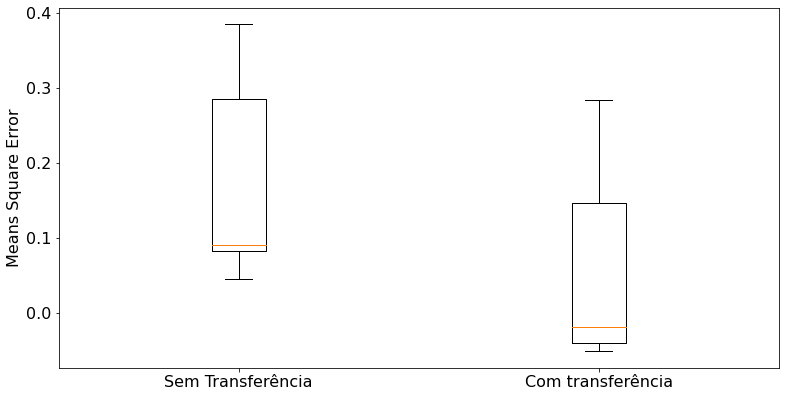

In [103]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np


# Creating dataset
np.random.seed(10)

data = [xx, xy]
plt.rcParams['font.size'] = '16'
fig = plt.figure(figsize =(10, 5))

# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])

# Creating plot
bp = ax.boxplot(data)

# x-axis labels
ax.set_xticklabels(['Sem Transferência', 'Com transferência'])
#ax.set_yticklabels("Means Square erro")
ax.set_ylabel("Means Square Error")

# show plot
plt.show()

In [104]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=benchmarking_analysis['value'], groups=benchmarking_analysis ['Transfer_Learning'], alpha=0.05)
print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
Com TF Sem TF   0.1224 0.0628 -0.0073 0.2522  False
---------------------------------------------------
